In [1]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
%matplotlib widget

In [2]:
import pandas as pd
import gurobipy   as      gp
from   gurobipy   import GRB
#from MasterProblemOMP import MasterProblem
#from SubProblemOMP import SubProblem
from plotDrawpointsPoints import plotDrawpointsPoints
from plotGurobiOpenPitSolution import plotGurobiOpenPitSolution
from plotIntegratedOmpSolution import plotIntegratedOmpSolution
from plotOmpOpenPitSolution import plotOmpOpenPitSolution
from plotUndergroundSolution import plotUndergroundSolution

Se cambió la definición de rho_v (el 1- no va), además se redifinió self.numberOfConstraints (se definió self.intNumberOfConstraints para calcular el óptimo). Se cambió como se calcula numberOfInvaiableBlocks

AL utilizar ql_t en 0.15 la solución objetivo se convierte en 0.0, estamos usando Ton * %Cu como ql, ¿Esta bien???, como se aplica ql, sobre cada bloque o sobre la suma de estos?, hay que cambiar la función de OMPsubproblem en función de esto 

In [3]:
#path = "C:/Users/willi/OneDrive/Escritorio/Magister/Tesis-Magister/Database/integratedModel/" #Notebook
path = "/home/williams/Tesis-Magister/Databases/"
#path = "C:/Users/Williams Medina/Desktop/Tesis Magister/Tesis-Magister/ThesisCode/MainCode/Databases/integratedModel/" #Desktop
undergroundDatabaseName = 'Modelo_F_OG.xlsx'
#openPitDatabaseName = 'Modelo_F_OG.xlsx'
openPitDatabaseName = 'Modelo_F_OG_4_4_4.xlsx'

In [4]:
if undergroundDatabaseName == openPitDatabaseName:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = undergroundMineDataframe
else:
    undergroundMineDataframe = pd.read_excel(path + undergroundDatabaseName, engine="openpyxl") #Notebook
    openPitDataframe = pd.read_excel(path + openPitDatabaseName, engine="openpyxl") #Notebook

In [5]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
import gurobipy   as     gp
from   gurobipy   import GRB
from drawpointFunction  import drawpointFunction
from globalFunctions import getNumberOfBlocksInADimension
from itertools import chain
from functools import reduce


class MasterProblem:
    #Underground Model + Crown Pillar Restrictions.
    def __init__(self, database, numberOfPeriods, colHeight, minColHeight,pos_x,pos_y,pos_z,pos_x_f,pos_y_f):
        self.database = database
        self.numberOfPeriods = numberOfPeriods
        self.DP_init = 0       #### Tipo de extracción
        self.desc = 0.1
        self.colHeight = colHeight#630#300
        self.minColHeight = minColHeight#0.20
        self.pos_x = pos_x     
        self.pos_y = pos_y   
        self.pos_z = pos_z
        self.pos_x_f = pos_x_f     
        self.pos_y_f = pos_y_f  
        self.p_t = 3791.912
        self.orientationToExtractTheDrawpoints = 0

    def setParameters(self):
        self.getUndergroundVariablesFromCSV()
        self.getUndergroundInfo()
        self.setUndergroundParameters()
        self.setUndergroundMineLimits()
        self.setUndergroundVariables()
        #self.setVandB_vParameters()

    
    def getUndergroundVariablesFromCSV(self):
        self.undergroundBlocksLenght = self.database['X'].to_dict()             
        self.undergroundBlocksWidth  = self.database['Y'].to_dict()             
        self.undergroundBlocksHeight = self.database['Z'].to_dict()             
        self.undergroundBlockTonnage = self.database['Ton'].to_dict()              
        self.undergroundBlockMineral  = self.database['Mineral'].to_dict()          
        self.undergroundBlockRecovery  = self.database['Recuperación'].to_dict()     
        self.undergroundCopperLaw  = self.database['%Cu'].to_dict()
        self.undergroundExtractionFixedCosts = self.database['CPlanta CA'].to_dict()
        self.undergroundVariableExtractionCosts = self.database['CMina CA'].to_dict()
        self.undergroundCP_S = self.database['CPlanta S'].to_dict()
        self.undergroundCM_S = self.database['CMINA S'].to_dict() 
    
    def getUndergroundInfo(self):
        self.undergroundBlocks = [i for i in range(len(self.undergroundBlocksLenght.values()))]

    def setUndergroundParameters(self):
        #Underground Parameters
        self.t_S   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.MU_mt = {period : 25806600.0  for period in range(self.numberOfPeriods)} #Tonleage es mina
        self.ML_mt = {period : 0/3  for period in range(self.numberOfPeriods)}
        self.MU_pt = {period : 17777880.0  for period in range(self.numberOfPeriods)}#Mineral es planta
        self.ML_pt = {period : 0/3 for period in range(self.numberOfPeriods)}
        self.qU_dt = {period : 1 for period in range(self.numberOfPeriods)}
        self.qL_dt = {period : 0.0001 for period in range(self.numberOfPeriods)}
        self.A_d   = {period : 2 for period in range(self.numberOfPeriods)}
        self.NU_nt = {period : 59 for period in range(self.numberOfPeriods)} 
        self.NL_nt = {period : 0 for period in range(self.numberOfPeriods)}
        self.N_t   = {period : 57* (1 + period) for period in range(self.numberOfPeriods)}
        self.RL_dt = {period : 0.25 for period in range(self.numberOfPeriods)}
        self.RU_dt = {period : 0.7 for period in range(self.numberOfPeriods)}

    def setUndergroundMineLimits(self):
        self.undergroundBlocksLenghtLimits = getNumberOfBlocksInADimension(self.undergroundBlocksLenght)
        self.undergroundBlocksWidthLimits = getNumberOfBlocksInADimension(self.undergroundBlocksWidth)
        self.undergroundBlocksHeightLimits = getNumberOfBlocksInADimension(self.undergroundBlocksHeight)

    def setUndergroundVariables(self):
        self.drawpoint, self.G_d, self.Q_d,self.q_d, self.C_pdt, self.C_mdt, self.predecessor, self.x_draw,self.y_draw, self.z_draw, self.drawpoints_blocks = drawpointFunction(
                        self.pos_x, self.pos_y, self.pos_z, self.colHeight, self.DP_init, self.undergroundBlocksLenghtLimits, self.undergroundBlocksWidthLimits, self.undergroundBlocksHeightLimits, self.undergroundBlockTonnage, self.undergroundCP_S, self.undergroundCM_S, self.undergroundBlockMineral,
                        self.undergroundCopperLaw, self.pos_x_f, self.pos_y_f,self.orientationToExtractTheDrawpoints)
        self.predecessorDict = {}
        self.predecessorDict[0] = []
        self.predecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            if self.predecessor[i][0] not in self.predecessorDict.keys():
                self.predecessorDict[self.predecessor[i][0]] = []
            self.predecessorDict[self.predecessor[i][0]].append(self.predecessor[i][1])
    """
    def setVandB_vParameters(self):
        self.setPossibleHeights()
        self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
        self.B_v = {}
        self.rho_v = {v: (v - self.minHeight)/(self.maxHeight - self.minHeight) for v in self.V}

        for v in self.V:
            numberOfBlocksBelowV = (self.undergroundBlocksLenghtLimits[3]*self.undergroundBlocksWidthLimits[3])*((v-self.minHeight)/self.undergroundBlocksHeightLimits[0])
            blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if not numberOfBlocksBelowV == 0]
            self.B_v[v] = blocksBelowV
    def setPossibleHeights(self):
        self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.undergroundBlocksHeightLimits
    """
    def setModelandGetResults(self):
        self.objValue, self.variableValues, self.runtime, self.gap = self.setUndergroundModel()

    def addThetaRestriction(self, subProblemObjValue, estimatedW_v, pi_vb):
        self.undergroundModel.addConstr(self.theta <= subProblemObjValue + gp.quicksum(gp.quicksum((self.w_v[v]-estimatedW_v[v]) * pi_vb[b] for b in self.B_v) for v in self.V))

    def setModel(self):
                                
        self.undergroundModel = gp.Model(name = 'Modelo Integrado')
        self.undergroundModel.Params.TimeLimit = 3600
        self.undergroundModel.Params.OutputFlag = 0

        # Underground  Model

              #14. Naturaleza de las variables
        self.x_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="x")
        self.y_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.CONTINUOUS, name="y")
        self.z_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="z")

        #1. Restricción sobre la cantidad de tonelaje máxima y mínima a extraer en cada periodo.
        Ton_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti]*self.G_d[d] for d in self.drawpoint) <= self.MU_mt[ti] for ti in self.t_S),
                                         "Min_max")
        
        Ton_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.G_d[d] for d in self.drawpoint) >= self.ML_mt[ti] for ti in self.t_S),
                                            "Min_min")
        #2. Restricción sobre la cantidad de material máxima y mínima a procesar en cada periodo.
        Mat_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) <= self.MU_pt[ti] for ti in self.t_S),
                                            "Mat_max")

        Mat_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) >= self.ML_pt[ti] for ti in self.t_S)
                                            , "Mat_min")
        #3. Rango de leyes máximas y mínimas a procesar
        GQC_low = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) >=
                                self.qL_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_low")
        
        GQC_Up = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) <=
                                self.qU_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_Up")

        #4. Todos los puntos de extracción deben ser iniciados en el largo de la extracción
        Drawp_init = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for ti in self.t_S) == 1 for d in self.drawpoint), "Drawp_init")

        #5. Los puntos de extracción deben ser activados al menos en el mismo periodo para que se inicie la extracción 
        Drawpextract_61 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, tau] for tau in range(ti+1)) >= self.z_dt[d, ti]  
                                            for d in self.drawpoint for ti in self.t_S), "Drawpextract_61")


        #6. Existe una cantidad máxima y mínima de drawpoints a abrir en cada periodo.
        Drawpextract_64_1 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.NU_nt[ti] for ti 
                                                        in self.t_S)
                                                        ,"Drawpextract_64_1")
        Drawpextract_64_2 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) >= self.NL_nt[ti] for ti 
                                                        in self.t_S)
                                                        , "Drawpextract_64_2")

        #7. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        Drawpextract_65 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")


        #8. Si iniciamos la extracción de un drawpoint esta debe durar por su duraci ́on determinada.
        ## Un drawpoint solamente puede ser extraido por un preiodo pre determinado (A_d)
        Drawpextract_62 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for ti in self.t_S)  <= self.A_d[ti]  for d in self.drawpoint
                                                    for ti in self.t_S), "Drawp_62")

        ## Una vez se inicia extrayendo de un drawpoint, se continua extrayendo sin interrupción
        Drawpextract_63 = self.undergroundModel.addConstrs((self.A_d[ti] *(self.z_dt[d, ti] - self.z_dt[d, ti+1]) 
                                            - gp.quicksum(self.z_dt[d, tau] for tau in range(ti+1)) <= 0 
                                            for d in self.drawpoint for ti in range(0,max(self.t_S))), "Drawpextract_63")

        #9. Relación de variables, el porcentaje a extraer es 0 si no se extra un drawpoint.
        Drawpextract_66 = self.undergroundModel.addConstrs((self.y_dt[d, ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S),
                                                    "Drawpextract_66")

        #10. Existe una tasa m ́ınima de extracci ́on para cada drawpoint a extraer.
        Drawpextract_67_1 = self.undergroundModel.addConstrs((self.RL_dt[ti] * self.z_dt[d, ti]  <=  self.y_dt[d, ti] for d in self.drawpoint
                                                        for ti in self.t_S), "Drawpextract_67_1")

        #11. La altura a extraer debe ser mayor a una cantidad m ́ınima.
        rest_11 = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d,ti] for ti in self.t_S)>= self.minColHeight for d in self.drawpoint))

        #12. No podemos extraer más del 100 % de un drawpoint.
        Reserver_cnst = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] for ti in self.t_S) <= 1 for d in self.drawpoint),
                                                    "Reserver_cnst")

        #13. Si se activa un drawpoint, se extrae en ese periodo
        rest_13 = self.undergroundModel.addConstrs(self.x_dt[d,ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S)

        #14. Naturaleza de variables.

        #15. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        rest_15 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")
        
        #16. Restricción sobre el inicio de la extracci ́on de los drawpoints.


        alternative = self.undergroundModel.addConstrs(gp.quicksum(self.x_dt[a,s] for s in range(0,ti+1)) >= self.x_dt[d, ti] for d in self.drawpoint for ti in self.t_S for a in self.predecessorDict[d])
        #resta_prec = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[self.predecessor[l][0], m]*(max(self.t_S)-m+1) for m in self.t_S) <=
        #                            gp.quicksum(self.x_dt[self.predecessor[l][1], m]*(max(self.t_S)-m+1) for m in self.t_S)  
        #                            for l in range(len(self.predecessor))), "DP_Sup")

        
        #Conjuntos para el crown pillar

        #Restricciones del crown pillar
        #Variable 1 si y solo si el crown pillar esta ubicado en la elevaci ́on v, 0 en otro caso.
        self.w_v = self.undergroundModel.addVars(self.V, vtype=GRB.BINARY, name="w")
        self.theta = self.undergroundModel.addVar(vtype=GRB.CONTINUOUS,name="theta")


        pillar_2 = self.undergroundModel.addConstrs(gp.quicksum(self.y_dt[d, ti] 
                                                        for ti in self.t_S) <= self.rho_v[v] * self.w_v[v] + (1 - self.w_v[v]) for v in self.V for d in self.drawpoint)
       
        pillar_3 = self.undergroundModel.addConstr(gp.quicksum(self.w_v[v] for v in self.V) == 1)

        theta_restriction_1 = self.undergroundModel.addConstr(-gp.GRB.INFINITY <= self.theta)
        theta_restriction_2 = self.undergroundModel.addConstr(self.theta <= 90000000000)

         #Función objetivo
        self.undergroundObjectiveFunction = self.theta + gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        ((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)

        self.undergroundModel.setObjective(self.undergroundObjectiveFunction, GRB.MAXIMIZE)
        self.undergroundModel.Params.MIPGap = 0.05


    def optimize(self):
        self.undergroundModel.optimize()
        self.lista_variable_Integrado = (self.undergroundModel.getAttr(GRB.Attr.X, self.undergroundModel.getVars()))
        solucion = self.undergroundModel.objVal
        runtime = self.undergroundModel.Runtime
        gap_f = self.undergroundModel.MIPGap
        estimatedW_v = {key:value.X for key,value in self.w_v.items()}
        self.selectedHeight = [key for key,value in estimatedW_v.items() if value == 1][0]
        self.x_dt_values = self.undergroundModel.getAttr('X', self.x_dt)
        self.y_dt_values = self.undergroundModel.getAttr('X', self.y_dt)
        self.z_dt_values = self.undergroundModel.getAttr('X', self.z_dt)
        return estimatedW_v, self.theta


In [6]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')

from   gurobipy   import GRB
from globalFunctions import getNumberOfBlocksInADimension
from openPitFunctions import finalBlock
from itertools import chain
import re
import subprocess as sp


class SubProblem:
   def __init__(self, database, minHeightUnderground, maxHeightUnderground,numberOfPeriods, safetyLevel):
      self.database = database
      self.numberOfPeriods = numberOfPeriods
      self.minHeightUnderground = minHeightUnderground
      self.maxHeightUnderground = maxHeightUnderground
      self.safetyLevel = safetyLevel
      self.numberOfDestinations = 1
      self.basePrice = 3791.912
      self.desc = 0.1

   def setParameters(self):
      self.setOpenPitVariables()
      self.getOpenPitInfo()
      self.setOpenPitParameters()
      self.setOpenPitMineLimits()
      self.setPossibleHeights()
      self.setHeightSets()

   def execute(self, B_v, isFinalIteration = False):
      self.createOmpInput(B_v)
      return (self.executeOmp(isFinalIteration))

   def setOpenPitVariables(self):
      self.openPitBlocksLength = self.database['X'].to_dict() 
      self.openPitBlocksWidth = self.database['Y'].to_dict() 
      self.openPitBlocksHeight = self.database['Z'].to_dict() #Los bloques se orientan de abajo hacia arriba, el bloque 0 es el que esta más abajo, 784 bloques
      self.L_b = self.database['Ton'].to_dict() #openPitBlockTonnage
      self.o_b = self.database['Mineral'].to_dict() #openPitBlockMineral
      self.openPitBlockRecovery = self.database['Recuperación'].to_dict() #openPitBlockRecovery
      self.openPitCopperLaw = self.database['%Cu'].to_dict() #openPitCopperLaw
      self.c_pbt = self.database['CPlanta CA'].to_dict() #openPitPlantCapacity
      self.c_mbt = self.database['CMina CA'].to_dict() #openPitMineCapacity

   def getOpenPitInfo(self):
      self.openPitBlocks = [i for i in range(len(self.openPitBlocksLength.values()))]

   def setOpenPitParameters(self):
      #OpenPit Parameters
      self.t_C   = {period : period + 1 for period in range(self.numberOfPeriods)}
      self.RMu_t = {period : 25806600.0 for period in range(self.numberOfPeriods)}#Superior infinita, 0 por abajo Originales: 13219200
      self.RMl_t = {period : 0.0/3 for period in range(self.numberOfPeriods)}#Valor original 8812800.0
      self.RPu_t = {period : 17777880.0 for period in range(self.numberOfPeriods)}#Valor original 10933380.0
      self.RPl_t = {period : 0/3 for period in range(self.numberOfPeriods)}#Valor original 7288920.0 
      self.qu_t  = {period : 1 for period in range(self.numberOfPeriods)}#Leyes promedio maxima y minima.
      self.ql_t  = {period : 0.0001 for period in range(self.numberOfPeriods)}
      self.delta = {period: 0 for period in range(self.numberOfPeriods)}
      self.maxTimeOpenPit = self.t_C[max(self.t_C)]


   def setOpenPitMineLimits(self):
      self.openPitBlocksLengthLimits = getNumberOfBlocksInADimension(self.openPitBlocksLength)
      self.openPitBlocksWidthLimits = getNumberOfBlocksInADimension(self.openPitBlocksWidth)
      self.openPitBlocksHeightLimits = getNumberOfBlocksInADimension(self.openPitBlocksHeight)
      self.predecessorBlock = self.setPredecessorBlocks()

   def setPredecessorBlocks(self):
      self.predecessorBlocks = finalBlock(self.openPitBlocks, self.openPitBlocksLengthLimits,self.openPitBlocksWidthLimits, self.openPitBlocksHeightLimits)
  
   def setPossibleHeights(self):
      self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.openPitBlocksHeightLimits
   
   def setHeightSets(self):
      #Acá hay que redifinir self.B_v para que tenga las alturas de maxheight al sumarle el safetylvl

      self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
      self.B_v = {}
      self.rho_v = {v:( ((v- self.safetyLevel - self.minHeightUnderground)/(self.maxHeightUnderground - self.minHeightUnderground)) if v - self.minHeightUnderground > 0 else 0 ) for v in self.V}

      for v in self.V:
         numberOfBlocksBelowV = (self.openPitBlocksLengthLimits[3]*self.openPitBlocksWidthLimits[3])*((v-self.minHeight)/self.openPitBlocksHeightLimits[0])
         blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if not numberOfBlocksBelowV == 0]
         self.B_v[v] = blocksBelowV
         
   def createOmpInput(self, infeasibleBlocks):
      self.writeProblemFile()
      self.writeBlocksFile(infeasibleBlocks)
      self.writePrecFile()
      self.writeParamsFile()
   
   def writeProblemFile(self):
         with open('../FilesToExecuteOmpOpenPit/files/openPit.prob', 'w') as f:
            numberOfDestinations = 'NDESTINATIONS: ' + str(self.numberOfDestinations)
            numberOfPeriods = 'NPERIODS: ' + str(self.numberOfPeriods)
            objective = 'OBJECTIVE: 0 1'
            duration = 'DURATION: 2'
            discountRate = 'DISCOUNT_RATE: '+ str(self.desc)#/self.numberOfPeriods)
            
            tonUpConstraint = 'CONSTRAINT: 0 3 P * L '
            for rmu in self.RMu_t.values():
               tonUpConstraint +=str(rmu) + " "

            tonLowContraint = 'CONSTRAINT: 1 3 P * G '
            for rml in self.RMl_t.values():
               tonLowContraint +=str(rml) + " "
            
            matUpConstraint = 'CONSTRAINT: 2 4 P * L '
            for rpu in self.RPu_t.values():
               matUpConstraint +=str(rpu) + " "

            matLowConstraint = 'CONSTRAINT: 3 4 P * G '
            for rpl in self.RPl_t.values():
               matLowConstraint +=str(rpl) + " "
            """
            #las siguientes dos restricciones tienen 0 en vez de qut y qlt ya que pasamos la desigualdad hacia la derecha en las lineas 144 y 145
            copperLawUpConstraint = 'CONSTRAINT: 4 5 B * L ' 
            for qut in self.qu_t.values():
               copperLawUpConstraint += "0 "
            
            copperLawLowConstraint = 'CONSTRAINT: 5 6 B * G '
            for qlt in self.ql_t.values():
               copperLawLowConstraint +="0 "
            """
            infeasibleBlocks = 'CONSTRAINT: 4 7 P * L '
            for delta in self.delta.values():
               infeasibleBlocks +=str(delta) + " "
            
            constraints = [tonUpConstraint, tonLowContraint, matUpConstraint, matLowConstraint,infeasibleBlocks]# copperLawUpConstraint,copperLawLowConstraint,infeasibleBlocks]
            self.numberOfConstraints = len(constraints)
            self.nConstraints = 'NCONSTRAINTS: ' + str(self.numberOfConstraints)
            f.write('{}\n{}\n{}\n{}\n{}\n{}\n'.format(numberOfDestinations,numberOfPeriods, objective,duration,discountRate,self.nConstraints))
            f.write('{}\n{}\n{}\n{}\n{}'.format(*constraints)) #\n{}\n{}\n'.format(*constraints))

   def writeBlocksFile(self, numberOfInvaiableBlocks):
      #print(f'Se optimizó el subproblema con {numberOfInvaiableBlocks} bloques infactibles')
      with open('../FilesToExecuteOmpOpenPit/files/openPit.blocks', 'w') as f:
         for block in self.openPitBlocks:
            index = block
            value = ((self.basePrice*self.openPitCopperLaw[block]-self.c_pbt[block])*self.o_b[block])-(self.c_mbt[block]*self.L_b[block])
            duration = 1 #Cuanto se demora en extraer el bloque
            ton = self.L_b[block]
            mineral = self.o_b[block]
            copperLawUpper = self.openPitCopperLaw[block] * self.L_b[block] - self.qu_t[0] * self.L_b[block]
            copperLawLower = self.openPitCopperLaw[block] * self.L_b[block] - self.ql_t[0] * self.L_b[block]

            #1 si no se puede extraer, 10977 última capa, los bloques van de abajo hacia arriba, 0 primer bloque de abajo, 10977 última capa hacia arriba, con 10975 la sol es vacia
            if block < numberOfInvaiableBlocks:
               f.write(('{} {} {} {} {} {} {} {}\n').format(index, value, duration, ton, mineral,copperLawUpper, copperLawLower, 1))
            else:
               f.write(('{} {} {} {} {} {} {} {}\n').format(index, value, duration, ton, mineral,copperLawUpper, copperLawLower, 0))
                 
   def writePrecFile(self):
      with open('../FilesToExecuteOmpOpenPit/files/openPit.prec', 'w') as f:
         for index,blockList in enumerate(self.predecessorBlocks):
            predecessorLine = str(len(blockList))
            for block in blockList:
               if block == index:
                  predecessorLine = " 0"
                  break
               else:
                  predecessorLine +=" " + str(block)
            f.write("{} {}\n".format(index, predecessorLine))
            
   def writeParamsFile(self):
      with open('../FilesToExecuteOmpOpenPit/params/openPit.params', 'w') as f:
         f.write("""USE_DISPLAY: 1
WRITE.LP.SOLUTION: 1
WRITE.IP.SOLUTION: 1
CPIT: 1
PP.ULTIMATE_PIT: 1
PP.FORCE_UPIT: 1
PP.EARLY_START: 1
PP.WASTE_OPTION: 1
PP.ELIM_NULL: 0
PP.TRANSITIVE_REDUCTION: 0
AG.USE_BLOCK_AGGREGATION: 0
AG.BLOCK_AGGREGATION: 0
OPTMETHOD: 0
CG.ONE_DESTINATION: 1
CG.IMPLICIT: 0
CG.USE_DISPLAY: 1
CG.MAX_ITER: -1
CG.TARGET_GAP: 0.0001
CG.MAX_TIME: -1
CG.USE_KSTEP: 0
CG.KSTEP_K: 10
CG.MASTER_NTHREADS: 4
CG.DISPLAY_DUALS: 1
HE.TOPOSORT: 1
HE.FTOPOSORT: 0
HE.NALPHA_POINTS: 50
HE.OPT_DESTINATIONS: 1
HE.NAIVE: 0
HE.NAIVE_INTSOLLIM: 1000
HE.NAIVE_EPGAP: 0.01
HE.NAIVE_TILIM: 14400
CP.DYNAMIC_CUTS: 0
CP.CLIQUES: 0
CP.MINW: 0
CP.DELAYED_PRECEDENCES: 0
CONSTRAINT_PROGRAMMING: 0
CPROG.GAP_LIMIT: 0.01
CPROG.CP_TIME_LIMIT: 28800
CPROG.EX_TIME_LIMIT: 28800
CPROG.HOT_START: 1
CPROG.NTHREADS: 8""")

   def executeOmp(self, isFinalIteration):
      output = sp.getoutput("./omp.sh ../FilesToExecuteOmpOpenPit/files/openPit.* ../FilesToExecuteOmpOpenPit/params/dbs_duals.params")
      #print(output)
      return self.getPiAndObjectiveValue(output, isFinalIteration)
   
   def getPiAndObjectiveValue(self, output, isFinalIteration):
      objective_value_to_use = 0
      if isFinalIteration:
         objective_value_to_use = 1
      pi_positions = [positions.start() for positions in re.finditer("rhs= 0.000000", output)]
      pi_t = dict.fromkeys(self.t_C,0)
      for pos in pi_positions:
         pi_value = float(output[pos-48: pos].split()[-3])
         pi_index = float(output[pos-48: pos].split()[-5])
         period_index = pi_index - self.numberOfPeriods * (self.numberOfConstraints - 1)
         pi_t[period_index] = pi_value

      objective_value_positions = [positions.start() for positions in re.finditer("Objective Value ", output)]
      objective_value = float(output[objective_value_positions[objective_value_to_use]: objective_value_positions[objective_value_to_use]+100].split()[-3])
      return objective_value, pi_t 


In [7]:
class Main:
    def __init__(self, undergroundMineDataframe, openPitDataframe):
        self.openPitDataframe = openPitDataframe
        self.undergroundMineDataframe = undergroundMineDataframe
        self.numberOfPeriods = 5
        self.epsilon = 100000
        self.safetyLevel = 60
        self.colHeight = 790#300 max 630 altura total de los drawpoints
        self.minColHeight = 0.40
        self.pos_x = 440#440#Coordenada x desde donde empezamos a extraer     
        self.pos_y = 550#550#Coordenada y desde donde empezamos a extraer
        self.pos_z = 530#780#Coordenada z desde donde empezamos a extraer     
        self.pos_x_f = 720#720#Coordenada x hazta donde extrameos  
        self.pos_y_f = 910#910#Coordenada y hazta donde extrameos
        
    def execute(self):
        self.createModels()
        self.setMasterProblemCrownPillarHeights()
        self.getResults()
    
    def createModels(self):
        self.createSubProblem()
        self.createMasterProblem()

    def createSubProblem(self):
        self.SubProblem = SubProblem(self.openPitDataframe, self.pos_z, self.pos_z + self.colHeight ,self.numberOfPeriods, self.safetyLevel)
        self.SubProblem.setParameters()

    def createMasterProblem(self):
        self.MasterProblem = MasterProblem(self.undergroundMineDataframe, self.numberOfPeriods,self.colHeight,self.minColHeight ,self.pos_x, self.pos_y, self.pos_z, self.pos_x_f, self.pos_y_f)
        self.MasterProblem.setParameters()
        
    def setMasterProblemCrownPillarHeights(self):
        self.MasterProblem.V, self.MasterProblem.rho_v = self.SubProblem.V, self.SubProblem.rho_v
        self.MasterProblem.B_v = self.SubProblem.B_v
    
    """
    def calculateInvaiableBlocksWithSafetyLevel(self, selectedHeight):
        heightWithSafetyLevel = selectedHeight# + self.safetyLevel
        if heightWithSafetyLevel not in self.MasterProblem.B_v.keys():
            closestHeight = next((height for height in sorted(self.MasterProblem.V) if height >= heightWithSafetyLevel), None)
            if closestHeight == None:
                return len(self.SubProblem.openPitBlocks)
            return len(self.MasterProblem.B_v[closestHeight])
        return len(self.MasterProblem.B_v[heightWithSafetyLevel])
    """

    def getResults(self):
        it = 0
        self.MasterProblem.setModel()
        currentTheta = -1000000000
        while True:
            it += 1
            self.estimatedW_v, self.estimatedTheta = self.MasterProblem.optimize()
            print(self.MasterProblem.undergroundModel.objVal)
            numberOfInvaiableBlocks = len(self.MasterProblem.B_v[self.MasterProblem.selectedHeight])
            self.subProblemObjValue, self.pi_vb = self.SubProblem.execute(numberOfInvaiableBlocks, isFinalIteration = False)
            print(it, "Objective Value =", self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue)
            print(f'Underground obj value: {self.MasterProblem.undergroundModel.objVal}')
            print("w_v: {}".format(self.MasterProblem.selectedHeight ))
            print("Master theta: {}".format(self.MasterProblem.theta))
            print("Current theta: {}".format(currentTheta))
            print(f' Underground Objective value: {self.MasterProblem.undergroundModel.objVal-self.MasterProblem.theta.X} \n OpenPit Objective Value {self.subProblemObjValue}\n Current Theta: {self.MasterProblem.theta.X}')

            
            if abs(self.MasterProblem.theta.X - currentTheta) <= self.epsilon:
                objVal = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
                self.subProblemObjValue, self.pi_vb = self.SubProblem.execute(numberOfInvaiableBlocks, isFinalIteration = True) #esto se cambia si queremos poner toposort
                currentTheta = self.estimatedTheta.X
                self.estimatedW_v, self.estimatedTheta = self.MasterProblem.optimize()
                print("-----------------------------Valor óptimo encontrado-----------------------------")
                print("Optimal Crown Pillar height: {}".format(self.MasterProblem.selectedHeight ))
                print(self.estimatedW_v)
                print("Optimal ObjVal: {}".format(self.MasterProblem.undergroundModel.objVal))
 
                toposort = self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue
                print("Optimal Theta: {}".format(self.MasterProblem.theta.X))
                print("Optimal ObjVal relaxed: {}".format(objVal))
                print("Master problem obj val: {}".format(self.MasterProblem.undergroundModel.objVal))
                print("Optimal ObjVal TopoSort: {}".format(toposort))
                print(f"GAP: {100 * (objVal-toposort)/objVal}")
                print(self.MasterProblem.selectedHeight,numberOfInvaiableBlocks)
                #print("Current theta: {}".format(currentTheta))
                break
            

            currentTheta = self.estimatedTheta.X
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * len(self.MasterProblem.B_v[v]) * (self.estimatedW_v[v] - self.MasterProblem.w_v[v]) for t in self.MasterProblem.t_S) for v in self.MasterProblem.V))

            #MEEJOR
            self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * len(self.MasterProblem.B_v[v]) * (-self.MasterProblem.w_v[v] +self.estimatedW_v[v]) for t in self.MasterProblem.t_S) for v in self.MasterProblem.V))
            
            
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * len(self.MasterProblem.B_v[v]) * (self.estimatedW_v[v] - self.MasterProblem.w_v[v]) for t in self.MasterProblem.t_S) for v in self.MasterProblem.V))

            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum(self.pi_vb[t] * numberOfInvaiableBlocks * (self.estimatedW_v[v] - self.MasterProblem.w_v[v]) for v in self.MasterProblem.V) for t in self.MasterProblem.t_S))
            print()
            print()

In [8]:
main2 = Main(undergroundMineDataframe, openPitDataframe)
main2.execute()

3391
Set parameter Username
Academic license - for non-commercial use only - expires 2023-10-02
Set parameter TimeLimit to value 3600
91339387055.01247
1 Objective Value = 1444797055.0124664
Underground obj value: 91339387055.01247
w_v: 1305
Master theta: <gurobi.Var theta (value 90000000000.0)>
Current theta: -1000000000
 Underground Objective value: 1339387055.0124664 
 OpenPit Objective Value 105410000.0
 Current Theta: 90000000000.0


76588351440.58353
2 Objective Value = 2262669492.761078
Underground obj value: 76588351440.58353
w_v: 985
Master theta: <gurobi.Var theta (value 75363181947.82245)>
Current theta: 90000000000.0
 Underground Objective value: 1225169492.761078 
 OpenPit Objective Value 1037500000.0
 Current Theta: 75363181947.82245


2262669492.761077
3 Objective Value = 2262669492.761077
Underground obj value: 2262669492.761077
w_v: 985
Master theta: <gurobi.Var theta (value 1037500000.0)>
Current theta: 75363181947.82245
 Underground Objective value: 1225169492.761077

In [9]:
main2.MasterProblem.undergroundModel.objVal-main2.MasterProblem.theta.X , main2.subProblemObjValue, main2.MasterProblem.theta.X

(1225169492.761077, 982590000.0, 1037500000.0)

In [10]:
main2.MasterProblem.undergroundModel.objVal

2262669492.761077

In [11]:
for v in main2.MasterProblem.B_v:
    print(v,len(main2.MasterProblem.B_v[v]), main2.MasterProblem.B_v[v])

745 0 []
785 784 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 21

In [12]:
class IntegratedModel:
    def __init__(self, undergroundMineDataframe, openMineDataframe, numberOfPeriods):
        self.openMineDataframe = openMineDataframe
        self.undergroundMineDataframe = undergroundMineDataframe
        self.numberOfPeriods = numberOfPeriods
        self.safetyLevel = 60
        self.colHeight = 790#630#self.undergroundBlocksHeightLimits[1] - self.undergroundBlocksHeightLimits[2]
        self.minColHeight = 0.40
        self.pos_x = 440#440#Coordenada x desde donde empezamos a extraer     
        self.pos_y = 550#550#Coordenada y desde donde empezamos a extraer
        self.pos_z = 530#780#Coordenada z desde donde empezamos a extraer     
        self.pos_x_f = 720#720#Coordenada x hazta donde extrameos  
        self.pos_y_f = 910#910#Coordenada y hazta donde extrameos
        self.p_t = 3791.912 
        self.desc = 0.1
        self.DP_init = 0       #### Tipo de extracción
        self.orientationToExtractTheDrawpoints = 0


    def execute(self):
        self.setOpenPitVariables()
        self.setUndergroundVariables()
        self.setMineLimits()
        self.getBlockInfo()
        self.setParametersToEvaluate()
        self.setGlobalParameters()
        self.getUndergroundVariables()
        self.setPossibleHeights()
        self.setModelAndGetResults()  
        return self.objValue, self.variableValues, self.runtime, self.gap , self.x_dt_values, self.y_dt_values, self.z_dt_values, self.x_bt_values

    def setOpenPitVariables(self):
        self.openPitBlocksLength = self.openMineDataframe['X'].to_dict() 
        self.openPitBlocksWidth = self.openMineDataframe['Y'].to_dict() 
        self.openPitBlocksHeight = self.openMineDataframe['Z'].to_dict() 
        self.L_b = self.openMineDataframe['Ton'].to_dict() #openPitBlockTonnage
        self.o_b = self.openMineDataframe['Mineral'].to_dict() #openPitBlockMineral
        self.openPitBlockRecovery = self.openMineDataframe['Recuperación'].to_dict() #openPitBlockRecovery
        self.openPitCopperLaw = self.openMineDataframe['%Cu'].to_dict() #openPitCopperLaw
        self.c_pbt = self.openMineDataframe['CPlanta CA'].to_dict() #openPitPlantCapacity
        self.c_mbt = self.openMineDataframe['CMina CA'].to_dict() #openPitMineCapacity
      
    def setUndergroundVariables(self):
        self.undergroundBlocksLength = self.undergroundMineDataframe['X'].to_dict()             
        self.undergroundBlocksWidth  = self.undergroundMineDataframe['Y'].to_dict()             
        self.undergroundBlocksHeight = self.undergroundMineDataframe['Z'].to_dict()             
        self.undergroundBlockTonnage = self.undergroundMineDataframe['Ton'].to_dict()              
        self.undergroundBlockMineral  = self.undergroundMineDataframe['Mineral'].to_dict()          
        self.undergroundBlockRecovery  = self.undergroundMineDataframe['Recuperación'].to_dict()     
        self.undergroundCopperLaw  = self.undergroundMineDataframe['%Cu'].to_dict()
        self.undergroundExtractionFixedCosts = self.undergroundMineDataframe['CPlanta CA'].to_dict()
        self.undergroundVariableExtractionCosts = self.undergroundMineDataframe['CMina CA'].to_dict()
        self.undergroundCP_S = self.undergroundMineDataframe['CPlanta S'].to_dict()
        self.undergroundCM_S = self.undergroundMineDataframe['CMINA S'].to_dict() 

    def setMineLimits(self):
        self.undergroundBlocksLenghtLimits = getNumberOfBlocksInADimension(self.undergroundBlocksLength)
        self.undergroundBlocksWidthLimits = getNumberOfBlocksInADimension(self.undergroundBlocksWidth)
        self.undergroundBlocksHeightLimits = getNumberOfBlocksInADimension(self.undergroundBlocksHeight)

        self.openPitBlocksLengthLimits = getNumberOfBlocksInADimension(self.openPitBlocksLength)
        self.openPitBlocksWidthLimits = getNumberOfBlocksInADimension(self.openPitBlocksWidth)
        self.openPitBlocksHeightLimits = getNumberOfBlocksInADimension(self.openPitBlocksHeight)

    def getBlockInfo(self):
        self.openPitBlocks = [i for i in range(len(self.openPitBlocksLength.values()))]
        self.S_blocks = [i for i in range(len(self.undergroundBlocksLength.values()))]

    def setParametersToEvaluate(self):
        #OpenPit Parameters
        self.t_C   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.RMu_t = {period : 25806600.0 for period in range(self.numberOfPeriods)}#Superior infinita, 0 por abajo Originales: 13219200
        self.RMl_t = {period : 0.0/3 for period in range(self.numberOfPeriods)}#Valor original 8812800.0
        self.RPu_t = {period : 17777880.0 for period in range(self.numberOfPeriods)}#Valor original 10933380.0
        self.RPl_t = {period : 0/3 for period in range(self.numberOfPeriods)}#Valor original 7288920.0 
        self.qu_t  = {period : 1 for period in range(self.numberOfPeriods)}#Leyes promedio maxima y minima.
        self.ql_t  = {period : 0.0001 for period in range(self.numberOfPeriods)}


        #Underground Parameters
        self.t_S   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.MU_mt = {period : 25806600.0  for period in range(self.numberOfPeriods)} #Tonleage es mina
        self.ML_mt = {period : 0/3  for period in range(self.numberOfPeriods)}
        self.MU_pt = {period : 17777880.0  for period in range(self.numberOfPeriods)}#Mineral es planta
        self.ML_pt = {period : 0/3 for period in range(self.numberOfPeriods)}
        self.qU_dt = {period : 1 for period in range(self.numberOfPeriods)}
        self.qL_dt = {period : 0.0001 for period in range(self.numberOfPeriods)}
        self.A_d   = {period : 2 for period in range(self.numberOfPeriods)}
        self.NU_nt = {period : 59 for period in range(self.numberOfPeriods)} 
        self.NL_nt = {period : 0 for period in range(self.numberOfPeriods)}
        self.N_t   = {period : 57 * (1 + period) for period in range(self.numberOfPeriods)}
        self.RL_dt = {period : 0.25 for period in range(self.numberOfPeriods)}
        self.RU_dt = {period : 0.7 for period in range(self.numberOfPeriods)}

            
        self.maxTimeOpenPit = self.t_C[max(self.t_C)]
        self.maxTimeUnderground = self.t_S[max(self.t_S)]

    def setGlobalParameters(self):
        self.setMineLimits()
        self.predecessorBlock = self.setPredecessorBlock()
        self.predecessorsBlocks = {}
        
        for blocklist in self.predecessorBlock:
            if blocklist[0] not in self.predecessorsBlocks.keys():
                self.predecessorsBlocks[blocklist[0]] = []
            if blocklist[0] != blocklist[1]:
                self.predecessorsBlocks[blocklist[0]].append(blocklist[1])

        self.dif_centroide = self.openPitBlocksLengthLimits[0]//2 - self.undergroundBlocksLenghtLimits[0]//2


    def setPredecessorBlock(self):
        predecessorBlock = []
        superiorBlock = finalBlock(self.openPitBlocks, self.openPitBlocksLengthLimits,self.openPitBlocksWidthLimits, self.openPitBlocksHeightLimits)
        for i in range(len(self.openPitBlocks)):
            for j in superiorBlock[i]:
                aux_1 = []
                aux_1.append(self.openPitBlocks[i])
                aux_1.append(j)
                predecessorBlock.append(aux_1)
        
        return predecessorBlock

    def getUndergroundVariables(self):
        
  
        
        self.drawpoint, self.G_d, self.Q_d,self.q_d, self.C_pdt, self.C_mdt, self.predecessor, self.x_draw,self.y_draw, self.z_draw, self.drawpoints_blocks = drawpointFunction(
                        self.pos_x, self.pos_y, self.pos_z, self.colHeight, self.DP_init, self.undergroundBlocksLenghtLimits, self.undergroundBlocksWidthLimits, self.undergroundBlocksHeightLimits, self.undergroundBlockTonnage, self.undergroundCP_S, self.undergroundCM_S, self.undergroundBlockMineral,
                        self.undergroundCopperLaw, self.pos_x_f, self.pos_y_f,self.orientationToExtractTheDrawpoints)
        """
        self.drawpointsPredecessorDict = {}
        self.drawpointsPredecessorDict[0] = []
        self.drawpointsPredecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            self.drawpointsPredecessorDict[self.predecessor[i][0]] =  [*reduce(lambda x, y: set(x) | set(y), self.predecessor[:i])]
        """ 
        self.drawpointsPredecessorDict = {}
        self.drawpointsPredecessorDict[0] = []
        self.drawpointsPredecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            if self.predecessor[i][0] not in self.drawpointsPredecessorDict.keys():
                self.drawpointsPredecessorDict[self.predecessor[i][0]] = []
            self.drawpointsPredecessorDict[self.predecessor[i][0]].append(self.predecessor[i][1])
          
           
    def setPossibleHeights(self):
        self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.openPitBlocksHeightLimits

    def setModelAndGetResults(self):
        self.objValue, self.variableValues, self.runtime, self.gap = self.setIntegratedModel()

    def setIntegratedModel(self):
         
        self.integratedModel = gp.Model(name = 'Modelo Integrado')
        
        # Open Pit tengo la variable del modelo cielo abierto continua
        self.x_bt = self.integratedModel.addVars(self.t_C, self.openPitBlocks, vtype=GRB.CONTINUOUS, name="x_b")
        #1. Restricci ́on sobre la cantidad de tonelaje m ́axima y m ́ınima a extraer en cada periodo.
        openPitModel_Ton_Up  = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                                <= self.RMu_t[ti] for ti in self.t_C), "Ton_max")
        openPitModel_Ton_low = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) 
                                >= self.RMl_t[ti] for ti in self.t_C), "Ton_min")

        #2. Restricci ́on sobre la cantidad de material m ́axima y m ́ınima a extraer en cada periodo.
        openPitModel_Mat_Up_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) <= 
                                self.RPu_t[ti] for ti in self.t_C), "Mat_max")
        openPitModel_Mat_low_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.o_b[b] for b in self.openPitBlocks) >= 
                                self.RPl_t[ti] for ti in self.t_C), "Mat_min")

        #3. Restricci ́on de precedencia de los bloques a extraer, debemos extraer los 5 bloques superiores al bloque objetivo para sacar a este
        
        #BLOCK_SUP_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[s, self.predecessorBlock[l][0]]*(self.maxTimeOpenPit-s+1) for s in self.t_C) <= 
        #                              gp.quicksum(self.x_bt[s, self.predecessorBlock[l][1]]*(self.maxTimeOpenPit-s+1) for s in self.t_C)  
        #                           for l in range(len(self.predecessorBlock))), "Superior_Block")
        openPitModel_Precedence = self.integratedModel.addConstrs(gp.quicksum(self.x_bt[s,a] for s in range(0,ti+1)) >= self.x_bt[ti, b] for b in self.openPitBlocks for ti in self.t_C for a in self.predecessorsBlocks[b])


        #4. Restricci ́on sobre la ley m ́axima y m ́ınima por periodo.
        openPitModel_GQC_Up_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) <=
                            self.qu_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                                "openPitModel_GQC_Up")

        openPitModel_GQC_low_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b]*self.L_b[b]*self.openPitCopperLaw[b] for b in self.openPitBlocks) >=
                            self.ql_t[ti] * gp.quicksum(self.x_bt[ti, b]*self.L_b[b] for b in self.openPitBlocks) for ti in self.t_C), 
                                "openPitModel_GQC_LOW")

        #5. Podemos extraer el bloque en un solo periodo.
        openPitModel_Reserve_cons_OP = self.integratedModel.addConstrs((gp.quicksum(self.x_bt[ti, b] for ti in self.t_C) <= 1 for b in self.openPitBlocks), 
                                "openPitModel_Reserve_cons")

        #Función objetivo
        self.openPitObjectiveFunction = gp.quicksum(self.x_bt[ti, b]*((((self.p_t*self.openPitCopperLaw[b]-self.c_pbt[b])*self.o_b[b])-(self.c_mbt[b]*self.L_b[b]))/((1+self.desc)**self.t_C[ti]))
                    for ti in self.t_C for b in self.openPitBlocks)
        
        
        # Underground  Model

        #14. Naturaleza de las variables
        self.x_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="x_d")
        self.y_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.CONTINUOUS, name="y_d")
        self.z_dt = self.integratedModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="z_d")
        #self.x_dt  = self.integratedModel.addVars(self.drawpoint, self.t_S,lb=main2.MasterProblem.x_dt_values, ub=main2.MasterProblem.x_dt_values, vtype=gp.GRB.BINARY, name="x_d")
        #self.y_dt  = self.integratedModel.addVars(self.drawpoint, self.t_S,lb=main2.MasterProblem.y_dt_values, ub=main2.MasterProblem.y_dt_values, vtype=gp.GRB.CONTINUOUS, name="y_d")
        #self.z_dt  = self.integratedModel.addVars(self.drawpoint, self.t_S,lb=main2.MasterProblem.z_dt_values, ub=main2.MasterProblem.z_dt_values, vtype=gp.GRB.BINARY, name="z_d")

        #1. Restricción sobre la cantidad de tonelaje máxima y mínima a extraer en cada periodo.
        Ton_Up = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti]*self.G_d[d] for d in self.drawpoint) <= self.MU_mt[ti] for ti in self.t_S),
                                         "Min_max")
        
        Ton_low = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.G_d[d] for d in self.drawpoint) >= self.ML_mt[ti] for ti in self.t_S),
                                            "Min_min")
        #2. Restricción sobre la cantidad de material máxima y mínima a procesar en cada periodo.
        Mat_Up = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) <= self.MU_pt[ti] for ti in self.t_S),
                                            "Mat_max")

        Mat_low = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) >= self.ML_pt[ti] for ti in self.t_S)
                                            , "Mat_min")

        
        #3. Rango de leyes máximas y mínimas a procesar
        GQC_low = self.integratedModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) >=
                                self.qL_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_low")
        
        GQC_Up = self.integratedModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) <=
                                self.qU_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_Up")

        #4. Todos los puntos de extracción deben ser iniciados en el largo de la extracción
        Drawp_init = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for ti in self.t_S) == 1 for d in self.drawpoint), "Drawp_init")

        #5. Los puntos de extracción deben ser activados al menos en el mismo periodo para que se inicie la extracción 
        Drawpextract_61 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, tau] for tau in range(ti+1)) >= self.z_dt[d, ti]  
                                            for d in self.drawpoint for ti in self.t_S), "Drawpextract_61")


        #6. Existe una cantidad máxima y mínima de drawpoints a abrir en cada periodo.
        Drawpextract_64_1 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.NU_nt[ti] for ti 
                                                        in self.t_S)
                                                        ,"Drawpextract_64_1")
        Drawpextract_64_2 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) >= self.NL_nt[ti] for ti 
                                                        in self.t_S)
                                                        , "Drawpextract_64_2")

        #7. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        Drawpextract_65 = self.integratedModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")


        #8. Si iniciamos la extracción de un drawpoint esta debe durar por su duraci ́on determinada.
        ## Un drawpoint solamente puede ser extraido por un preiodo pre determinado (A_d)
        Drawpextract_62 = self.integratedModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for ti in self.t_S)  <= self.A_d[ti]  for d in self.drawpoint
                                                    for ti in self.t_S), "Drawp_62")

        ## Una vez se inicia extrayendo de un drawpoint, se continua extrayendo sin interrupción
        Drawpextract_63 = self.integratedModel.addConstrs((self.A_d[ti] *(self.z_dt[d, ti] - self.z_dt[d, ti+1]) 
                                            - gp.quicksum(self.z_dt[d, tau] for tau in range(ti+1)) <= 0 
                                            for d in self.drawpoint for ti in range(0,max(self.t_S))), "Drawpextract_63")

        #9. Relación de variables, el porcentaje a extraer es 0 si no se extra un drawpoint.
        Drawpextract_66 = self.integratedModel.addConstrs((self.y_dt[d, ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S),
                                                    "Drawpextract_66")

        #10. Existe una tasa m ́ınima de extracci ́on para cada drawpoint a extraer.
        Drawpextract_67_1 = self.integratedModel.addConstrs((self.RL_dt[ti] * self.z_dt[d, ti]  <=  self.y_dt[d, ti] for d in self.drawpoint
                                                        for ti in self.t_S), "Drawpextract_67_1")

        #11. La altura a extraer debe ser mayor a una cantidad m ́ınima.
        rest_11 = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d,ti] for ti in self.t_S)>= self.minColHeight for d in self.drawpoint))

        #12. No podemos extraer más del 100 % de un drawpoint.
        Reserver_cnst = self.integratedModel.addConstrs((gp.quicksum(self.y_dt[d, ti] for ti in self.t_S) <= 1 for d in self.drawpoint),
                                                    "Reserver_cnst")

        #13. Si se activa un drawpoint, se extrae en ese periodo
        rest_13 = self.integratedModel.addConstrs(self.x_dt[d,ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S)

        #14. Naturaleza de variables.

        #15. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        rest_15 = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")
        
        #16. Restricción sobre el inicio de la extracci ́on de los drawpoints.


        alternative = self.integratedModel.addConstrs(gp.quicksum(self.x_dt[a,s] for s in range(0,ti+1)) >= self.x_dt[d, ti] for d in self.drawpoint for ti in self.t_S for a in self.drawpointsPredecessorDict[d])
        #resta_prec = self.integratedModel.addConstrs((gp.quicksum(self.x_dt[self.predecessor[l][0], m]*(max(self.t_S)-m+1) for m in self.t_S) <=
        #                            gp.quicksum(self.x_dt[self.predecessor[l][1], m]*(max(self.t_S)-m+1) for m in self.t_S)  
        #                            for l in range(len(self.predecessor))), "DP_Sup")

        #Función objetivo
        
        self.undergroundObjectiveFunction = gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        ((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)

     
        

        self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
        self.rho_v = {v:( ((v- self.safetyLevel - self.pos_z)/(self.pos_z + self.colHeight  - self.pos_z)) if v - self.pos_z > 0 else 0 ) for v in self.V}
        self.B_v = {}
        for v in self.V:
            numberOfBlocksBelowV = (self.openPitBlocksLengthLimits[3]*self.openPitBlocksWidthLimits[3])*((v-self.minHeight)/self.openPitBlocksHeightLimits[0])
            blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if numberOfBlocksBelowV != 0]
            self.B_v[v] = blocksBelowV
        #self.B_v = sorted(self.B_v)
        """
        for v in self.V:
            heightWithSafetyLevel = v + self.safetyLevel
            if heightWithSafetyLevel not in self.B_v.keys():
                closestHeight = next((height for height in sorted(self.V) if height >= heightWithSafetyLevel), None)
                if closestHeight == None:
                    self.B_v[v + self.safetyLevel] = [block for block in range(len(self.openPitBlocks))]
                else:
                    self.B_v[v + self.safetyLevel] = [block for block in range(len(self.B_v[closestHeight]))]
        """
        #Restricciones del crown pillar

        #Variable 1 si y solo si el crown pillar esta ubicado en la elevaci ́on v, 0 en otro caso.
        self.w_v = self.integratedModel.addVars(self.V, vtype=GRB.BINARY, name="w")
        #self.w_v[745].lb = 1 con esta restricción podemos sacar resultados en función de las iteraciones de las alturas, ej: partir con w_v en diferentes alturas

        #Restricciones del crown pillar if v + self.safetyLevel < max(self.self.B_v.keys())

        
        pillar_1 = self.integratedModel.addConstrs(gp.quicksum(self.x_bt[ti, b] for ti in self.t_C) <= 1 - self.w_v[v] for v in (self.V) for b in self.B_v[v] )


        pillar_2 = self.integratedModel.addConstrs(gp.quicksum(self.y_dt[d, ti] 
                                                        for ti in self.t_S) <= self.rho_v[v] * self.w_v[v] + (1 - self.w_v[v]) for v in self.V for d in self.drawpoint)
       
        pillar_3 = self.integratedModel.addConstr(gp.quicksum(self.w_v[v] for v in self.V) == 1)
        
        #fixed_position = self.integratedModel.addConstrs(self.w_v == w_opt)
        integratedObjectiveFunction = self.undergroundObjectiveFunction + self.openPitObjectiveFunction

        
        self.integratedModel.setObjective(integratedObjectiveFunction, GRB.MAXIMIZE)
        self.integratedModel.Params.MIPGap = 0.05
        #self.integratedModel.Params.TimeLimit = 3600
        
        self.integratedModel.optimize()
        self.x_dt_values = self.integratedModel.getAttr('X', self.x_dt)
        self.y_dt_values = self.integratedModel.getAttr('X', self.y_dt)
        self.z_dt_values = self.integratedModel.getAttr('X', self.z_dt)
        self.x_bt_values = self.integratedModel.getAttr('X', self.x_bt)
        
        # Saca los valores de la solución
        lista_variable_Integrado = self.integratedModel.getAttr(GRB.Attr.X)
        solucion = self.integratedModel.objVal
        runtime = self.integratedModel.Runtime
        gap_f = self.integratedModel.MIPGap
        self.estimatedW_v = {key:value.X for key,value in self.w_v.items()}
        return solucion, lista_variable_Integrado, runtime, gap_f

In [13]:
numberOfPeriods = 5

In [14]:
mainIntegratedModel = IntegratedModel(undergroundMineDataframe, openPitDataframe, numberOfPeriods)

In [15]:
integratedObjValue, integratedVariableValues, integratedRuntime, integratedGap, x_dt_values, y_dt_values, z_dt_values, x_bt_values = mainIntegratedModel.execute()

3391
Set parameter MIPGap to value 0.05
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (linux64)
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads
Optimize a model with 369452 rows, 61335 columns and 1917162 nonzeros
Model fingerprint: 0x7d0bcfa7
Variable types: 59640 continuous, 1695 integer (1695 binary)
Coefficient statistics:
  Matrix range     [9e-02, 1e+06]
  Objective range  [9e+01, 4e+07]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 3e+07]
Presolve removed 215748 rows and 27936 columns
Presolve time: 3.02s
Presolved: 153704 rows, 33399 columns, 730539 nonzeros
Variable types: 33379 continuous, 20 integer (20 binary)
Found heuristic solution: objective 1.433834e+09

Deterministic concurrent LP optimizer: primal and dual simplex (primal and dual model)
Showing first log only...

Root relaxation presolve removed 2 rows and 1 columns
Root relaxation presolved: 153702 rows, 33398 columns, 730534 nonzeros


Root simplex log...

Iteration  

In [16]:
mainIntegratedModel.undergroundObjectiveFunction.getValue(), mainIntegratedModel.openPitObjectiveFunction.getValue()

(1225169492.7610765, 1868866824.6902647)

In [17]:
mainIntegratedModel.estimatedW_v

{745: 0.0,
 785: 0.0,
 825: 0.0,
 865: 0.0,
 905: 0.0,
 945: 0.0,
 985: 1.0,
 1025: -0.0,
 1065: 0.0,
 1105: 0.0,
 1145: 0.0,
 1185: 0.0,
 1225: 0.0,
 1265: -0.0,
 1305: -0.0}

In [18]:
import sys  
sys.path.insert(0, '../BendersProblems/')
%matplotlib widget

#from MasterProblem import MasterProblem
from SubProblem import SubProblem

In [60]:
import sys  
sys.path.insert(0, '../AuxiliarCodes/')
import gurobipy   as     gp
from   gurobipy   import GRB
from drawpointFunction  import drawpointFunction
from globalFunctions import getNumberOfBlocksInADimension
from itertools import chain
from functools import reduce


class MasterProblem:
    #Underground Model + Crown Pillar Restrictions.
    def __init__(self, database, numberOfPeriods, colHeight, minColHeight,pos_x,pos_y,pos_z,pos_x_f,pos_y_f):
        self.database = database
        self.numberOfPeriods = numberOfPeriods
        self.DP_init = 0       #### Tipo de extracción
        self.desc = 0.1
        self.colHeight = colHeight#630#300
        self.minColHeight = minColHeight#0.20
        self.pos_x = pos_x     
        self.pos_y = pos_y   
        self.pos_z = pos_z
        self.pos_x_f = pos_x_f     
        self.pos_y_f = pos_y_f  
        self.p_t = 3791.912
        self.orientationToExtractTheDrawpoints = 0

    def setParameters(self):
        self.getUndergroundVariablesFromCSV()
        self.getUndergroundInfo()
        self.setUndergroundParameters()
        self.setUndergroundMineLimits()
        self.setUndergroundVariables()
        #self.setVandB_vParameters()

    
    def getUndergroundVariablesFromCSV(self):
        self.undergroundBlocksLenght = self.database['X'].to_dict()             
        self.undergroundBlocksWidth  = self.database['Y'].to_dict()             
        self.undergroundBlocksHeight = self.database['Z'].to_dict()             
        self.undergroundBlockTonnage = self.database['Ton'].to_dict()              
        self.undergroundBlockMineral  = self.database['Mineral'].to_dict()          
        self.undergroundBlockRecovery  = self.database['Recuperación'].to_dict()     
        self.undergroundCopperLaw  = self.database['%Cu'].to_dict()
        self.undergroundExtractionFixedCosts = self.database['CPlanta CA'].to_dict()
        self.undergroundVariableExtractionCosts = self.database['CMina CA'].to_dict()
        self.undergroundCP_S = self.database['CPlanta S'].to_dict()
        self.undergroundCM_S = self.database['CMINA S'].to_dict() 
    
    def getUndergroundInfo(self):
        self.undergroundBlocks = [i for i in range(len(self.undergroundBlocksLenght.values()))]

    def setUndergroundParameters(self):
        #Underground Parameters
        self.t_S   = {period : period + 1 for period in range(self.numberOfPeriods)}
        self.MU_mt = {period : 25806600.0  for period in range(self.numberOfPeriods)} #Tonleage es mina
        self.ML_mt = {period : 0/3  for period in range(self.numberOfPeriods)}
        self.MU_pt = {period : 17777880.0  for period in range(self.numberOfPeriods)}#Mineral es planta
        self.ML_pt = {period : 0/3 for period in range(self.numberOfPeriods)}
        self.qU_dt = {period : 1 for period in range(self.numberOfPeriods)}
        self.qL_dt = {period : 0.0001 for period in range(self.numberOfPeriods)}
        self.A_d   = {period : 2 for period in range(self.numberOfPeriods)}
        self.NU_nt = {period : 59 for period in range(self.numberOfPeriods)} 
        self.NL_nt = {period : 0 for period in range(self.numberOfPeriods)}
        self.N_t   = {period : 57* (1 + period) for period in range(self.numberOfPeriods)}
        self.RL_dt = {period : 0.25 for period in range(self.numberOfPeriods)}
        self.RU_dt = {period : 0.7 for period in range(self.numberOfPeriods)}

    def setUndergroundMineLimits(self):
        self.undergroundBlocksLenghtLimits = getNumberOfBlocksInADimension(self.undergroundBlocksLenght)
        self.undergroundBlocksWidthLimits = getNumberOfBlocksInADimension(self.undergroundBlocksWidth)
        self.undergroundBlocksHeightLimits = getNumberOfBlocksInADimension(self.undergroundBlocksHeight)

    def setUndergroundVariables(self):
        self.drawpoint, self.G_d, self.Q_d,self.q_d, self.C_pdt, self.C_mdt, self.predecessor, self.x_draw,self.y_draw, self.z_draw, self.drawpoints_blocks = drawpointFunction(
                        self.pos_x, self.pos_y, self.pos_z, self.colHeight, self.DP_init, self.undergroundBlocksLenghtLimits, self.undergroundBlocksWidthLimits, self.undergroundBlocksHeightLimits, self.undergroundBlockTonnage, self.undergroundCP_S, self.undergroundCM_S, self.undergroundBlockMineral,
                        self.undergroundCopperLaw, self.pos_x_f, self.pos_y_f,self.orientationToExtractTheDrawpoints)
        self.predecessorDict = {}
        self.predecessorDict[0] = []
        self.predecessorDict[1] = [0]
        for i in range(1,len(self.predecessor)):
            if self.predecessor[i][0] not in self.predecessorDict.keys():
                self.predecessorDict[self.predecessor[i][0]] = []
            self.predecessorDict[self.predecessor[i][0]].append(self.predecessor[i][1])
    """
    def setVandB_vParameters(self):
        self.setPossibleHeights()
        self.V = [height for height in chain(range(self.minHeight,self.maxHeight,self.blockHeight), [self.maxHeight])]
        self.B_v = {}
        self.rho_v = {v: (v - self.minHeight)/(self.maxHeight - self.minHeight) for v in self.V}

        for v in self.V:
            numberOfBlocksBelowV = (self.undergroundBlocksLenghtLimits[3]*self.undergroundBlocksWidthLimits[3])*((v-self.minHeight)/self.undergroundBlocksHeightLimits[0])
            blocksBelowV = [block for block in range(int(numberOfBlocksBelowV)) if not numberOfBlocksBelowV == 0]
            self.B_v[v] = blocksBelowV
    def setPossibleHeights(self):
        self.blockHeight, self.maxHeight, self.minHeight, self.numOfDifferentsBlocks = self.undergroundBlocksHeightLimits
    """
    def setModelandGetResults(self):
        self.objValue, self.variableValues, self.runtime, self.gap = self.setUndergroundModel()

    def addThetaRestriction(self, subProblemObjValue, estimatedW_v, pi_vb):
        self.undergroundModel.addConstr(self.theta <= subProblemObjValue + gp.quicksum(gp.quicksum((self.w_v[v]-estimatedW_v[v]) * pi_vb[b] for b in self.B_v) for v in self.V))

    def setModel(self):
                                
        self.undergroundModel = gp.Model(name = 'Modelo Integrado')
        self.undergroundModel.Params.TimeLimit = 3600
        self.undergroundModel.Params.OutputFlag = 0

        # Underground  Model

              #14. Naturaleza de las variables
        self.x_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="x")
        self.y_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.CONTINUOUS, name="y")
        self.z_dt = self.undergroundModel.addVars(self.drawpoint, self.t_S, vtype=GRB.BINARY, name="z")

        #1. Restricción sobre la cantidad de tonelaje máxima y mínima a extraer en cada periodo.
        Ton_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti]*self.G_d[d] for d in self.drawpoint) <= self.MU_mt[ti] for ti in self.t_S),
                                         "Min_max")
        
        Ton_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.G_d[d] for d in self.drawpoint) >= self.ML_mt[ti] for ti in self.t_S),
                                            "Min_min")
        #2. Restricción sobre la cantidad de material máxima y mínima a procesar en cada periodo.
        Mat_Up = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) <= self.MU_pt[ti] for ti in self.t_S),
                                            "Mat_max")

        Mat_low = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] * self.Q_d[d] for d in self.drawpoint) >= self.ML_pt[ti] for ti in self.t_S)
                                            , "Mat_min")
        #3. Rango de leyes máximas y mínimas a procesar
        GQC_low = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) >=
                                self.qL_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_low")
        
        GQC_Up = self.undergroundModel.addConstrs((gp.quicksum(self.Q_d[d] * self.q_d[d] * self.y_dt[d, ti] for d in self.drawpoint) <=
                                self.qU_dt[ti] * gp.quicksum(self.G_d[d] * self.y_dt[d, ti] for d in self.drawpoint) for ti in self.t_S), "GQC_Up")

        #4. Todos los puntos de extracción deben ser iniciados en el largo de la extracción
        Drawp_init = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for ti in self.t_S) == 1 for d in self.drawpoint), "Drawp_init")

        #5. Los puntos de extracción deben ser activados al menos en el mismo periodo para que se inicie la extracción 
        Drawpextract_61 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, tau] for tau in range(ti+1)) >= self.z_dt[d, ti]  
                                            for d in self.drawpoint for ti in self.t_S), "Drawpextract_61")


        #6. Existe una cantidad máxima y mínima de drawpoints a abrir en cada periodo.
        Drawpextract_64_1 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.NU_nt[ti] for ti 
                                                        in self.t_S)
                                                        ,"Drawpextract_64_1")
        Drawpextract_64_2 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) >= self.NL_nt[ti] for ti 
                                                        in self.t_S)
                                                        , "Drawpextract_64_2")

        #7. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        Drawpextract_65 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")


        #8. Si iniciamos la extracción de un drawpoint esta debe durar por su duraci ́on determinada.
        ## Un drawpoint solamente puede ser extraido por un preiodo pre determinado (A_d)
        Drawpextract_62 = self.undergroundModel.addConstrs((gp.quicksum(self.z_dt[d, ti] for ti in self.t_S)  <= self.A_d[ti]  for d in self.drawpoint
                                                    for ti in self.t_S), "Drawp_62")

        ## Una vez se inicia extrayendo de un drawpoint, se continua extrayendo sin interrupción
        Drawpextract_63 = self.undergroundModel.addConstrs((self.A_d[ti] *(self.z_dt[d, ti] - self.z_dt[d, ti+1]) 
                                            - gp.quicksum(self.z_dt[d, tau] for tau in range(ti+1)) <= 0 
                                            for d in self.drawpoint for ti in range(0,max(self.t_S))), "Drawpextract_63")

        #9. Relación de variables, el porcentaje a extraer es 0 si no se extra un drawpoint.
        Drawpextract_66 = self.undergroundModel.addConstrs((self.y_dt[d, ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S),
                                                    "Drawpextract_66")

        #10. Existe una tasa m ́ınima de extracci ́on para cada drawpoint a extraer.
        Drawpextract_67_1 = self.undergroundModel.addConstrs((self.RL_dt[ti] * self.z_dt[d, ti]  <=  self.y_dt[d, ti] for d in self.drawpoint
                                                        for ti in self.t_S), "Drawpextract_67_1")

        #11. La altura a extraer debe ser mayor a una cantidad m ́ınima.
        rest_11 = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d,ti] for ti in self.t_S)>= self.minColHeight for d in self.drawpoint))

        #12. No podemos extraer más del 100 % de un drawpoint.
        Reserver_cnst = self.undergroundModel.addConstrs((gp.quicksum(self.y_dt[d, ti] for ti in self.t_S) <= 1 for d in self.drawpoint),
                                                    "Reserver_cnst")

        #13. Si se activa un drawpoint, se extrae en ese periodo
        rest_13 = self.undergroundModel.addConstrs(self.x_dt[d,ti] <= self.z_dt[d, ti] for d in self.drawpoint for ti in self.t_S)

        #14. Naturaleza de variables.

        #15. Existe una m ́axima cantidad de drawpoints a extraer por periodo.
        rest_15 = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[d, ti] for d in self.drawpoint) <= self.N_t[ti] for ti in self.t_S)
                                                    , "Drawpextract_65")
        
        #16. Restricción sobre el inicio de la extracci ́on de los drawpoints.


        alternative = self.undergroundModel.addConstrs(gp.quicksum(self.x_dt[a,s] for s in range(0,ti+1)) >= self.x_dt[d, ti] for d in self.drawpoint for ti in self.t_S for a in self.predecessorDict[d])
        #resta_prec = self.undergroundModel.addConstrs((gp.quicksum(self.x_dt[self.predecessor[l][0], m]*(max(self.t_S)-m+1) for m in self.t_S) <=
        #                            gp.quicksum(self.x_dt[self.predecessor[l][1], m]*(max(self.t_S)-m+1) for m in self.t_S)  
        #                            for l in range(len(self.predecessor))), "DP_Sup")

        
        #Conjuntos para el crown pillar

        #Restricciones del crown pillar
        #Variable 1 si y solo si el crown pillar esta ubicado en la elevaci ́on v, 0 en otro caso.
        test_w = {745: 0.0,
            785: 0.0,
            825: 0.0,
            865: 0.0,
            905: 0.0,
            945: 0.0,
            985: 1.0,
            1025: 0.0,
            1065: 0.0,
            1105: 0.0,
            1145: 0.0,
            1185: 0.0,
            1225: 0.0,
            1265: 0.0,
            1305: 0.0}
        #self.w_v = self.undergroundModel.addVars(self.V, vtype=GRB.BINARY, name="w")
        self.w_v = self.undergroundModel.addVars(self.V,lb=test_w, ub=test_w ,vtype=GRB.BINARY, name="w")

        self.theta = self.undergroundModel.addVar(vtype=GRB.CONTINUOUS,name="theta",lb=-GRB.INFINITY)


        pillar_2 = self.undergroundModel.addConstrs(gp.quicksum(self.y_dt[d, ti] 
                                                        for ti in self.t_S) <= self.rho_v[v] * self.w_v[v] + (1 - self.w_v[v]) for v in self.V for d in self.drawpoint)
       
        pillar_3 = self.undergroundModel.addConstr(gp.quicksum(self.w_v[v] for v in self.V) == 1)

        theta_restriction_2 = self.undergroundModel.addConstr(self.theta <= 900000000000)
        self.undergroundModel.addConstr(self.theta >= 98259000.0)

         #Función objetivo
        self.undergroundObjectiveFunction = self.theta + gp.quicksum(self.y_dt[d, ti]*((((self.p_t * self.q_d[d] - self.C_pdt[d] ) * self.Q_d[d])-(self.C_mdt[d]*self.G_d[d]))/
                                        ((1+self.desc)**(self.t_S[ti]))) for ti in self.t_S for d in self.drawpoint)

        self.undergroundModel.setObjective(self.undergroundObjectiveFunction, GRB.MAXIMIZE)
        self.undergroundModel.Params.MIPGap = 0.05


    def optimize(self):
        self.undergroundModel.optimize()
        self.lista_variable_Integrado = (self.undergroundModel.getAttr(GRB.Attr.X, self.undergroundModel.getVars()))
        solucion = self.undergroundModel.objVal
        runtime = self.undergroundModel.Runtime
        gap_f = self.undergroundModel.MIPGap
        estimatedW_v = {key:value.X for key,value in self.w_v.items()}
        self.selectedHeight = [key for key,value in estimatedW_v.items() if value == 1][0]
        self.x_dt_values = self.undergroundModel.getAttr('X', self.x_dt)
        self.y_dt_values = self.undergroundModel.getAttr('X', self.y_dt)
        self.z_dt_values = self.undergroundModel.getAttr('X', self.z_dt)
        return estimatedW_v, self.theta

In [61]:
class Main:
    def __init__(self, undergroundMineDataframe, openPitDataframe):
        self.openPitDataframe = openPitDataframe
        self.undergroundMineDataframe = undergroundMineDataframe
        self.numberOfPeriods = 5
        self.epsilon = 100000
        self.safetyLevel = 60
        self.colHeight = 790#300 max 630 altura total de los drawpoints
        self.minColHeight = 0.40
        self.pos_x = 440#440#Coordenada x desde donde empezamos a extraer     
        self.pos_y = 550#550#Coordenada y desde donde empezamos a extraer
        self.pos_z = 530#780#Coordenada z desde donde empezamos a extraer     
        self.pos_x_f = 720#720#Coordenada x hazta donde extrameos  
        self.pos_y_f = 910#910#Coordenada y hazta donde extrameos
        
    def execute(self):
        self.createModels()
        self.setMasterProblemCrownPillarHeights()
        self.getResults()
    
    def createModels(self):
        self.createSubProblem()
        self.createMasterProblem()

    def createSubProblem(self):
        self.SubProblem = SubProblem(self.openPitDataframe, self.pos_z, self.pos_z + self.colHeight ,self.numberOfPeriods, self.safetyLevel)
        self.SubProblem.setParameters()

    def createMasterProblem(self):
        self.MasterProblem = MasterProblem(self.undergroundMineDataframe, self.numberOfPeriods,self.colHeight,self.minColHeight ,self.pos_x, self.pos_y, self.pos_z, self.pos_x_f, self.pos_y_f)
        self.MasterProblem.setParameters()

        
    def setMasterProblemCrownPillarHeights(self):
        self.MasterProblem.V, self.MasterProblem.rho_v = self.SubProblem.V, self.SubProblem.rho_v
        self.MasterProblem.B_v = self.SubProblem.B_v



    def getResults(self):
        it = 0
        self.MasterProblem.setModel()
        self.SubProblem.setModel()

        #self.MasterProblem.x_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.x_dt_values, ub=main2.MasterProblem.x_dt_values, vtype=gp.GRB.BINARY, name="x_d")
        #self.MasterProblem.y_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.y_dt_values, ub=main2.MasterProblem.y_dt_values, vtype=gp.GRB.CONTINUOUS, name="y_d")
        #self.MasterProblem.z_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.z_dt_values, ub=main2.MasterProblem.z_dt_values, vtype=gp.GRB.BINARY, name="z_d")

     
        currentTheta = -100000000000
        while True:
            it +=1
            self.estimatedW_v, self.estimatedTheta = self.MasterProblem.optimize()
            print(self.MasterProblem.undergroundModel.objVal)

            self.subProblemObjValue, self.pi_vb = self.SubProblem.optimize(self.estimatedW_v)#testW_v
            print("Valor sin editar ", self.MasterProblem.undergroundModel.objVal)
            print(it, "Objective Value =", self.MasterProblem.undergroundModel.objVal - self.MasterProblem.theta.X + self.subProblemObjValue)
            print("w_v: {}".format(self.MasterProblem.selectedHeight))
            print("Master theta: {}".format(self.MasterProblem.theta))
            print("Current theta: {}".format(currentTheta))
            print(f'MasterProblem value: {self.MasterProblem.undergroundModel.objVal}\n Underground Objective value: {self.MasterProblem.undergroundModel.objVal-self.MasterProblem.theta.X} \n OpenPit Objective Value {self.subProblemObjValue}\n Current Theta: {self.MasterProblem.theta.X}')

            if abs(self.MasterProblem.theta.X - currentTheta) <= self.epsilon:
                #self.MasterProblem.x_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.x_dt_values, ub=main2.MasterProblem.x_dt_values, vtype=gp.GRB.BINARY, name="x_d")
                #self.MasterProblem.y_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.y_dt_values, ub=main2.MasterProblem.y_dt_values, vtype=gp.GRB.CONTINUOUS, name="y_d")
                #self.MasterProblem.z_dt  = self.MasterProblem.undergroundModel.addVars(self.MasterProblem.drawpoint, self.MasterProblem.t_S,lb=main2.MasterProblem.z_dt_values, ub=main2.MasterProblem.z_dt_values, vtype=gp.GRB.BINARY, name="z_d")

            
                #self.SubProblem.setModel(isFinalIteration = True)
                print()
                print("-----------------------------Valor óptimo encontrado-----------------------------")
                self.estimatedW_v, self.estimatedTheta = self.MasterProblem.optimize()
                self.subProblemObjValue, self.pi_vb = self.SubProblem.optimize(self.estimatedW_v)#testW_v
                print("Optimal Crown Pillar height: {}".format(self.MasterProblem.selectedHeight))
                print("Optimal ObjVal: {}".format(self.MasterProblem.undergroundModel.objVal- self.MasterProblem.theta.X + self.subProblemObjValue))
                print("Optimal Theta: {}".format(self.MasterProblem.theta.X))
                break
            print(self.SubProblem.pi_bDict == self.pi_vb)
            currentTheta = self.estimatedTheta.X
            a = 0
            for i in self.pi_vb:
                if self.pi_vb[i] != 0:
                    self.pi_vb[i]
            #self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <= self.subProblemObjValue + gp.quicksum(gp.quicksum((-self.MasterProblem.w_v[v] + self.estimatedW_v[v]) * self.pi_vb[v,b] for b in self.SubProblem.B_v[v]) for v in self.SubProblem.V))
            self.MasterProblem.undergroundModel.addConstr(self.MasterProblem.theta <=  gp.quicksum(gp.quicksum((1-self.MasterProblem.w_v[v]) * self.pi_vb[v,b] for b in self.SubProblem.B_v[v]) for v in self.SubProblem.V))

            #print(self.pi_vb)
            print()
            print()

In [62]:
main4 = Main(undergroundMineDataframe, openPitDataframe)
main4.execute()

3391
Set parameter TimeLimit to value 3600
90001225169492.77
La w_v que me llegó fue {745: 0.0, 785: 0.0, 825: 0.0, 865: 0.0, 905: 0.0, 945: 0.0, 985: 1.0, 1025: 0.0, 1065: 0.0, 1105: 0.0, 1145: 0.0, 1185: 0.0, 1225: 0.0, 1265: 0.0, 1305: 0.0}
Valor sin editar  90001225169492.77
1 Objective Value = 3094036317.45589
w_v: 985
Master theta: <gurobi.Var theta (value 90000000000000.0)>
Current theta: -100000000000
MasterProblem value: 90001225169492.77
 Underground Objective value: 1225169492.765625 
 OpenPit Objective Value 1868866824.6902652
 Current Theta: 90000000000000.0
True


2064599961.5627246
La w_v que me llegó fue {745: 0.0, 785: 0.0, 825: 0.0, 865: 0.0, 905: 0.0, 945: 0.0, 985: 1.0, 1025: 0.0, 1065: 0.0, 1105: 0.0, 1145: 0.0, 1185: 0.0, 1225: 0.0, 1265: 0.0, 1305: 0.0}
Valor sin editar  2064599961.5627246
2 Objective Value = 3094036317.4513416
w_v: 985
Master theta: <gurobi.Var theta (value 839430468.8016479)>
Current theta: 90000000000000.0
MasterProblem value: 2064599961.56272

GurobiError: Unable to retrieve attribute 'X'

In [22]:
main4.MasterProblem.undergroundModel.objVal-main4.MasterProblem.theta.X , main4.subProblemObjValue, main4.MasterProblem.theta.X

(1331648976.5617208, 95822740.97280003, 95822740.97280003)

In [23]:
main4.MasterProblem.w_v

{745: <gurobi.Var w[745] (value 0.0)>,
 785: <gurobi.Var w[785] (value 0.0)>,
 825: <gurobi.Var w[825] (value 0.0)>,
 865: <gurobi.Var w[865] (value 0.0)>,
 905: <gurobi.Var w[905] (value 0.0)>,
 945: <gurobi.Var w[945] (value 0.0)>,
 985: <gurobi.Var w[985] (value 0.0)>,
 1025: <gurobi.Var w[1025] (value 0.0)>,
 1065: <gurobi.Var w[1065] (value 0.0)>,
 1105: <gurobi.Var w[1105] (value 0.0)>,
 1145: <gurobi.Var w[1145] (value 0.0)>,
 1185: <gurobi.Var w[1185] (value 1.0)>,
 1225: <gurobi.Var w[1225] (value 0.0)>,
 1265: <gurobi.Var w[1265] (value 0.0)>,
 1305: <gurobi.Var w[1305] (value 0.0)>}

In [24]:
main4.estimatedW_v

{745: 0.0,
 785: 0.0,
 825: 0.0,
 865: 0.0,
 905: 0.0,
 945: 0.0,
 985: 0.0,
 1025: 0.0,
 1065: 0.0,
 1105: 0.0,
 1145: 0.0,
 1185: 1.0,
 1225: 0.0,
 1265: 0.0,
 1305: 0.0}

In [25]:
perro

NameError: name 'perro' is not defined

In [ ]:
main = Main(undergroundMineDataframe, undergroundMineDataframe)
main.execute()

3391
Set parameter TimeLimit to value 3600
91338411841.18846
1 Objective Value = 1352147841.1884613
Underground obj value: 91338411841.18846
w_v: 1320
Master theta: <gurobi.Var theta (value 90000000000.0)>
Current theta: -1000000000
 Underground Objective value: 1338411841.1884613 
 OpenPit Objective Value 13736000.0
 Current Theta: 90000000000.0


71512161340.04767
2 Objective Value = 2431971792.479019
Underground obj value: 71512161340.04767
w_v: 990
Master theta: <gurobi.Var theta (value 70272389547.56865)>
Current theta: 90000000000.0
 Underground Objective value: 1239771792.4790192 
 OpenPit Objective Value 1192200000.0
 Current Theta: 70272389547.56865


2431971792.4790354
3 Objective Value = 2431971792.4790354
Underground obj value: 2431971792.4790354
w_v: 990
Master theta: <gurobi.Var theta (value 1192200000.0)>
Current theta: 70272389547.56865
 Underground Objective value: 1239771792.4790354 
 OpenPit Objective Value 1192200000.0
 Current Theta: 1192200000.0


2431971792.47903

In [ ]:
#main2.MasterProblem.undergroundModel.objVal-main2.MasterProblem.theta.X , main2.subProblemObjValue, main2.MasterProblem.theta.X



/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotDrawpointsPoints.py:40: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


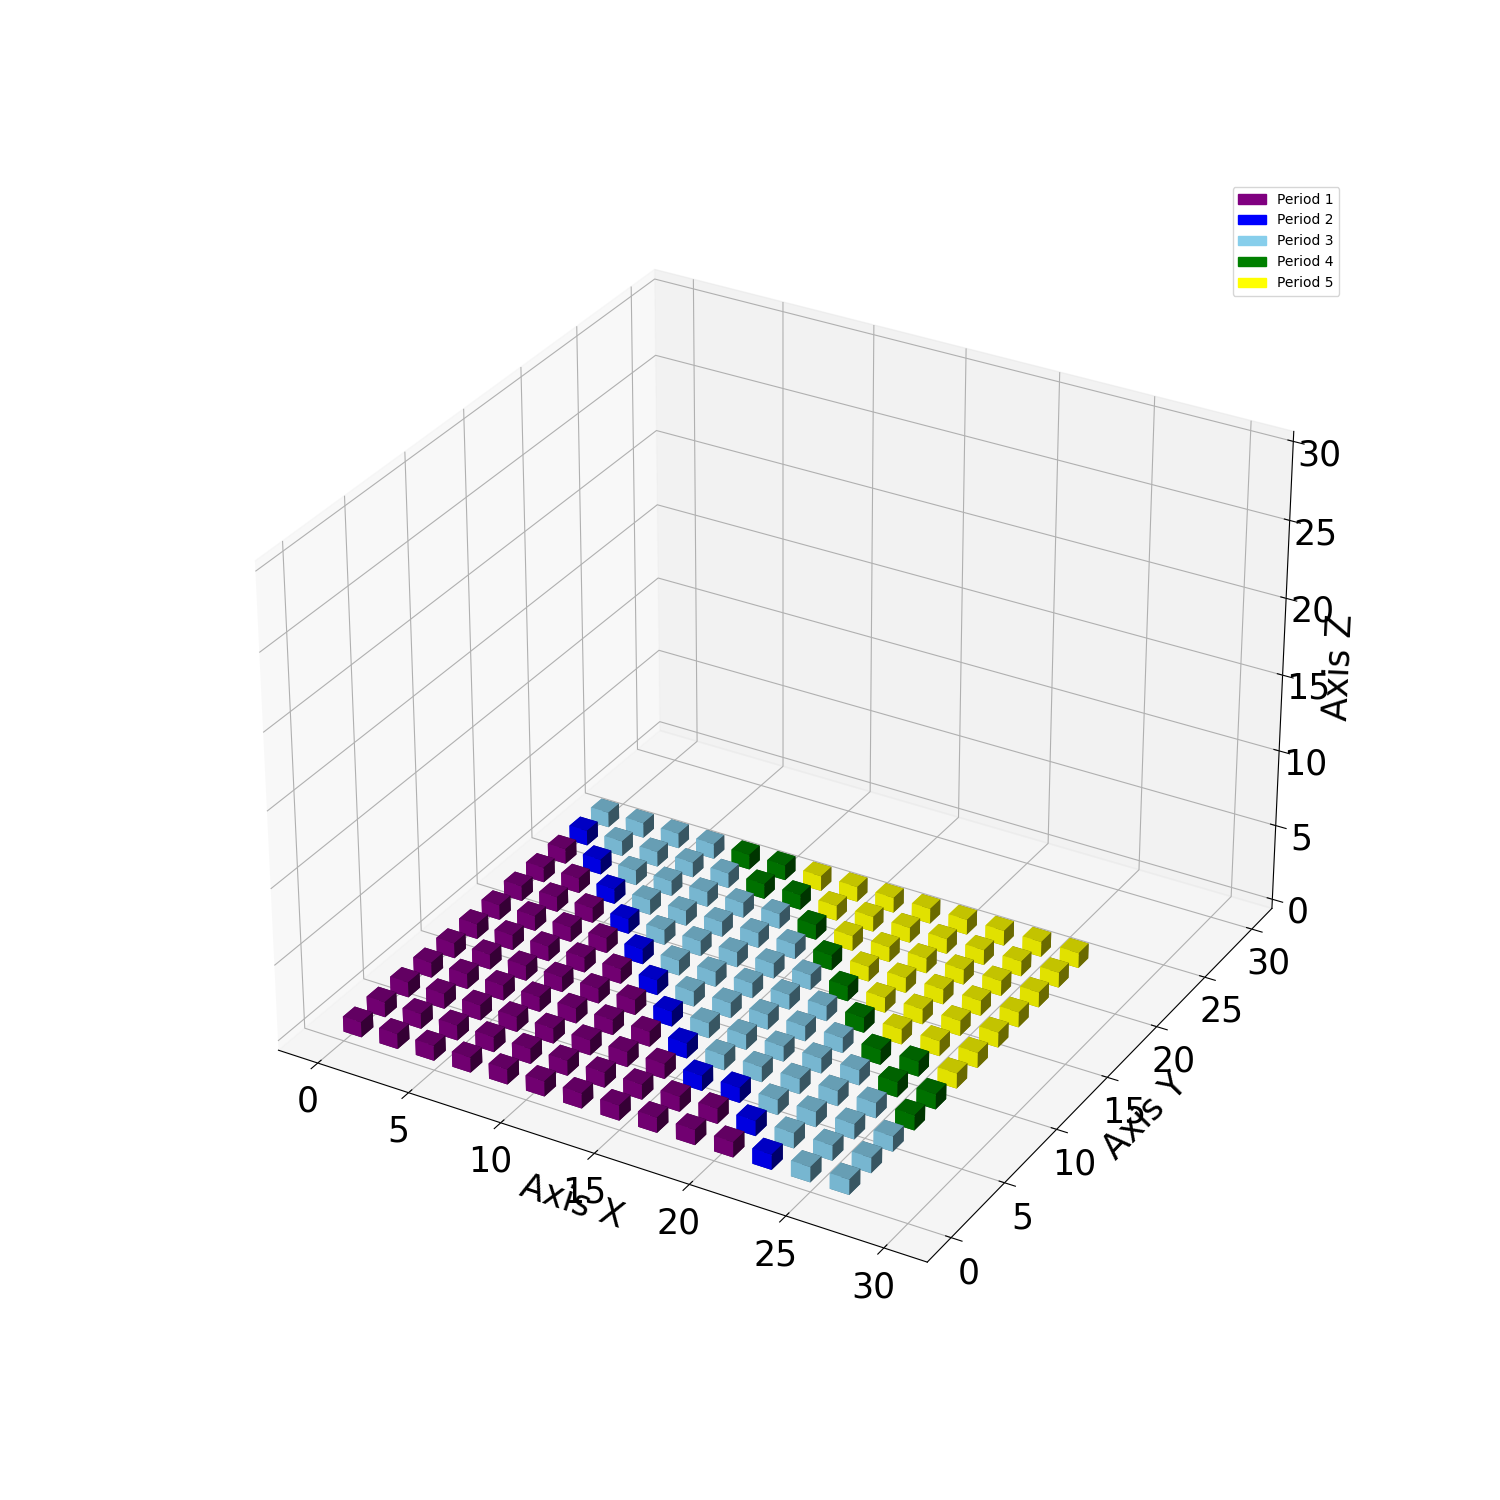

In [ ]:
plotDrawpointsPoints(len(main.MasterProblem.drawpoint),main.MasterProblem.x_dt_values,main.numberOfPeriods,main.MasterProblem.x_draw,main.MasterProblem.y_draw,main.MasterProblem.z_draw)

In [ ]:
# Creamos un diccionario vacío
data_dict = {}

# Abrimos el archivo en modo lectura
with open('openPit_openPit_dbs_duals.TOPOSORT.ip.sol', 'r') as file:
    for line in file:
        # Separamos la línea por espacios
        fields = line.split()

        # Convertimos el primer y tercer campo a int y lo añadimos al diccionario
        key = int(fields[0])
        value = int(fields[2])

        data_dict[key] = value

# Imprimimos el diccionario
print(data_dict)
openPitDict = data_dict

{581320: 4, 581431: 4, 581432: 4, 581433: 4, 581542: 4, 581543: 4, 581544: 4, 581545: 4, 581546: 4, 581653: 4, 581654: 4, 581655: 3, 581656: 3, 581657: 4, 581658: 4, 581659: 4, 581764: 4, 581766: 3, 581767: 3, 581768: 3, 581769: 3, 581770: 4, 581771: 4, 581772: 4, 581876: 4, 581877: 3, 581878: 3, 581879: 3, 581880: 3, 581881: 3, 581882: 3, 581883: 4, 581884: 4, 581885: 4, 581987: 4, 581988: 3, 581989: 3, 581990: 3, 581991: 3, 581992: 3, 581993: 3, 581994: 3, 581995: 3, 581996: 4, 581997: 4, 581998: 4, 582100: 4, 582101: 3, 582102: 3, 582103: 3, 582104: 3, 582105: 3, 582106: 3, 582107: 3, 582108: 3, 582109: 4, 582110: 4, 582111: 4, 582212: 3, 582213: 3, 582214: 3, 582215: 3, 582216: 3, 582217: 3, 582218: 3, 582219: 3, 582220: 4, 582221: 4, 582222: 4, 582223: 4, 582323: 4, 582324: 4, 582325: 3, 582326: 3, 582327: 3, 582328: 3, 582329: 3, 582330: 3, 582331: 4, 582332: 4, 582333: 4, 582334: 4, 582435: 4, 582436: 4, 582437: 4, 582439: 3, 582440: 3, 582441: 3, 582442: 4, 582443: 4, 582444: 4

In [ ]:
limites_x_C = main.SubProblem.openPitBlocksLengthLimits 
limites_y_C = main.SubProblem.openPitBlocksWidthLimits 
limites_z_C = main.SubProblem.openPitBlocksHeightLimits 

/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotUndergroundSolution.py:48: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


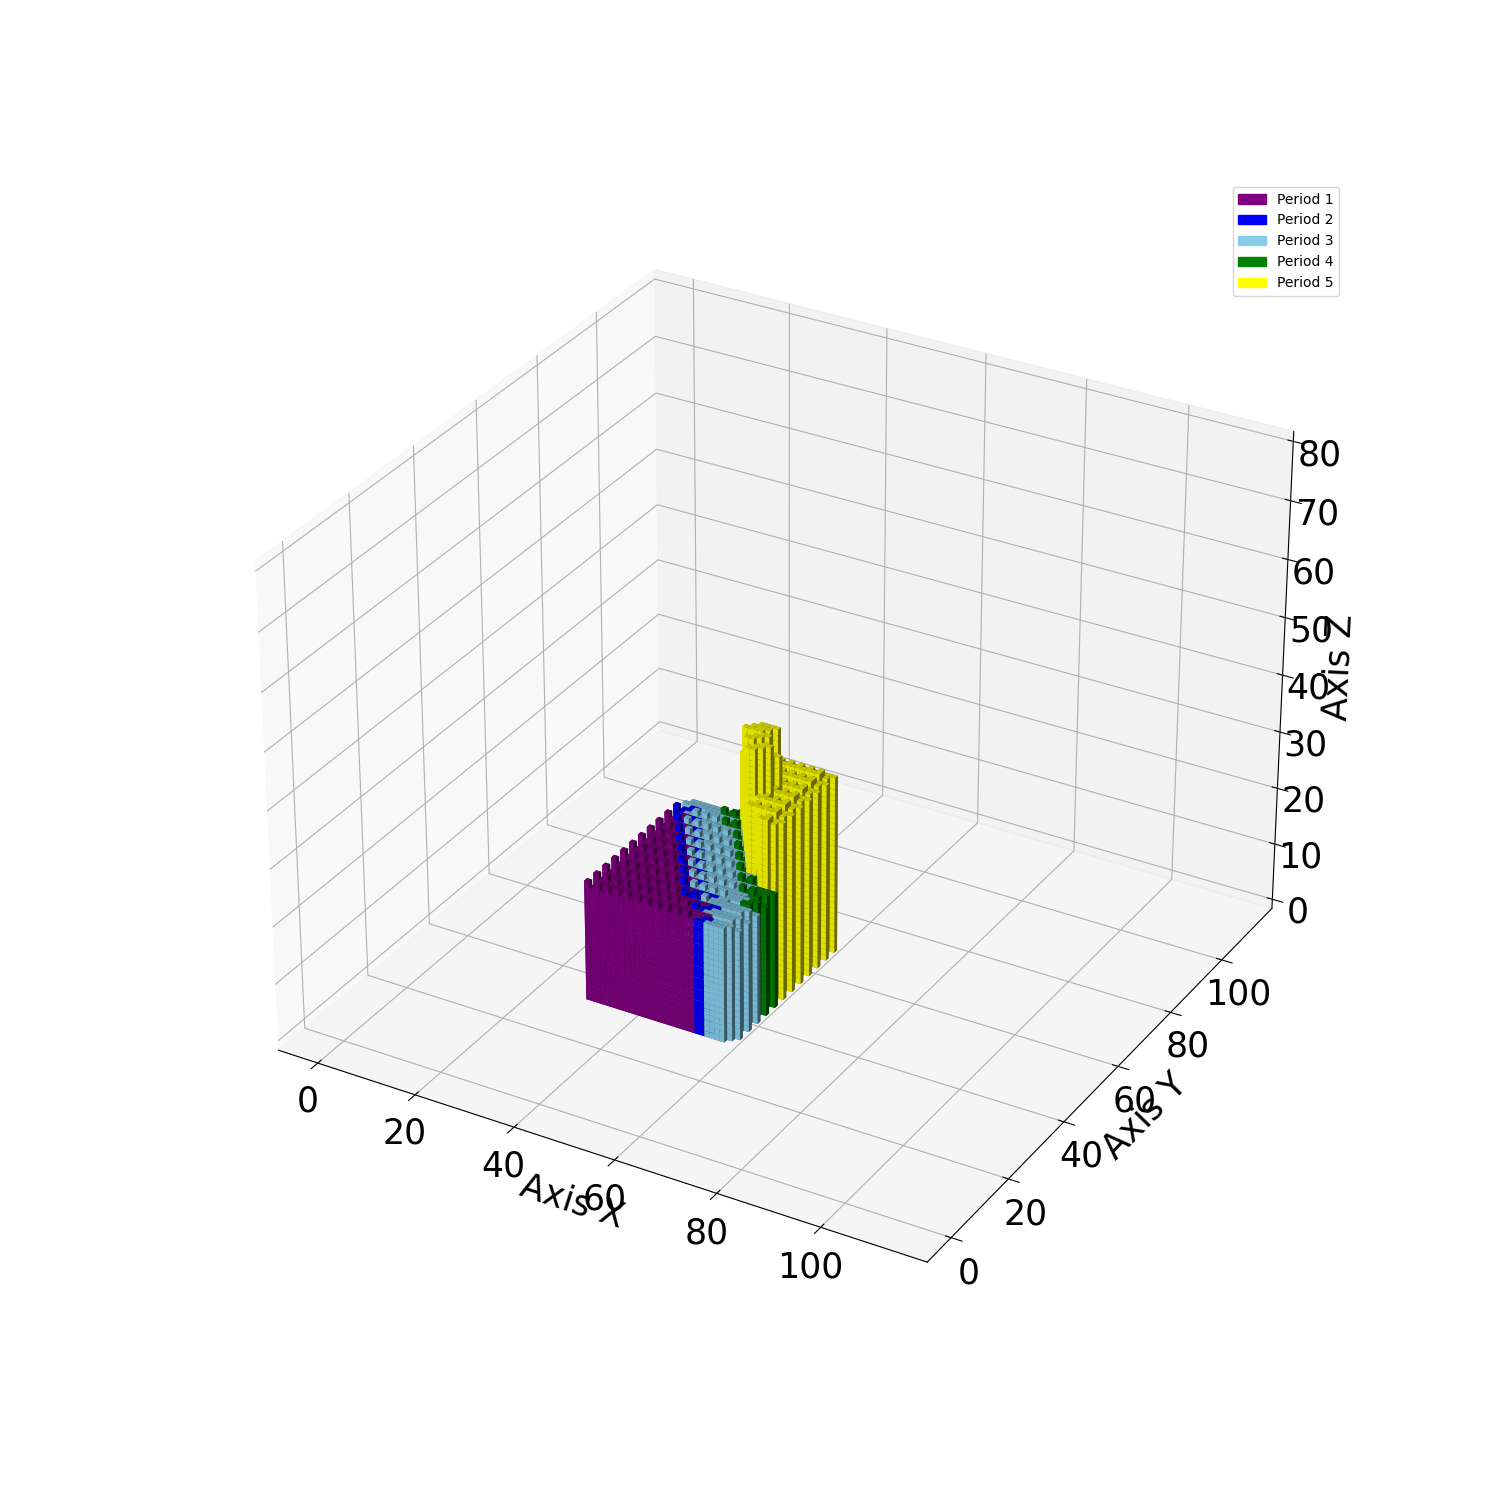

In [ ]:
plotUndergroundSolution(main.MasterProblem.undergroundBlocksLenghtLimits, main.MasterProblem.undergroundBlocksWidthLimits,main.MasterProblem.undergroundBlocksHeightLimits, main.MasterProblem.drawpoints_blocks,main.MasterProblem.x_dt_values , main.MasterProblem.y_dt_values, main.numberOfPeriods)

/home/williams/Tesis-Magister/Codes/JupyterCodes/../AuxiliarCodes/plotIntegratedOmpSolution.py:58: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  plt.legend(["a"],["b"])


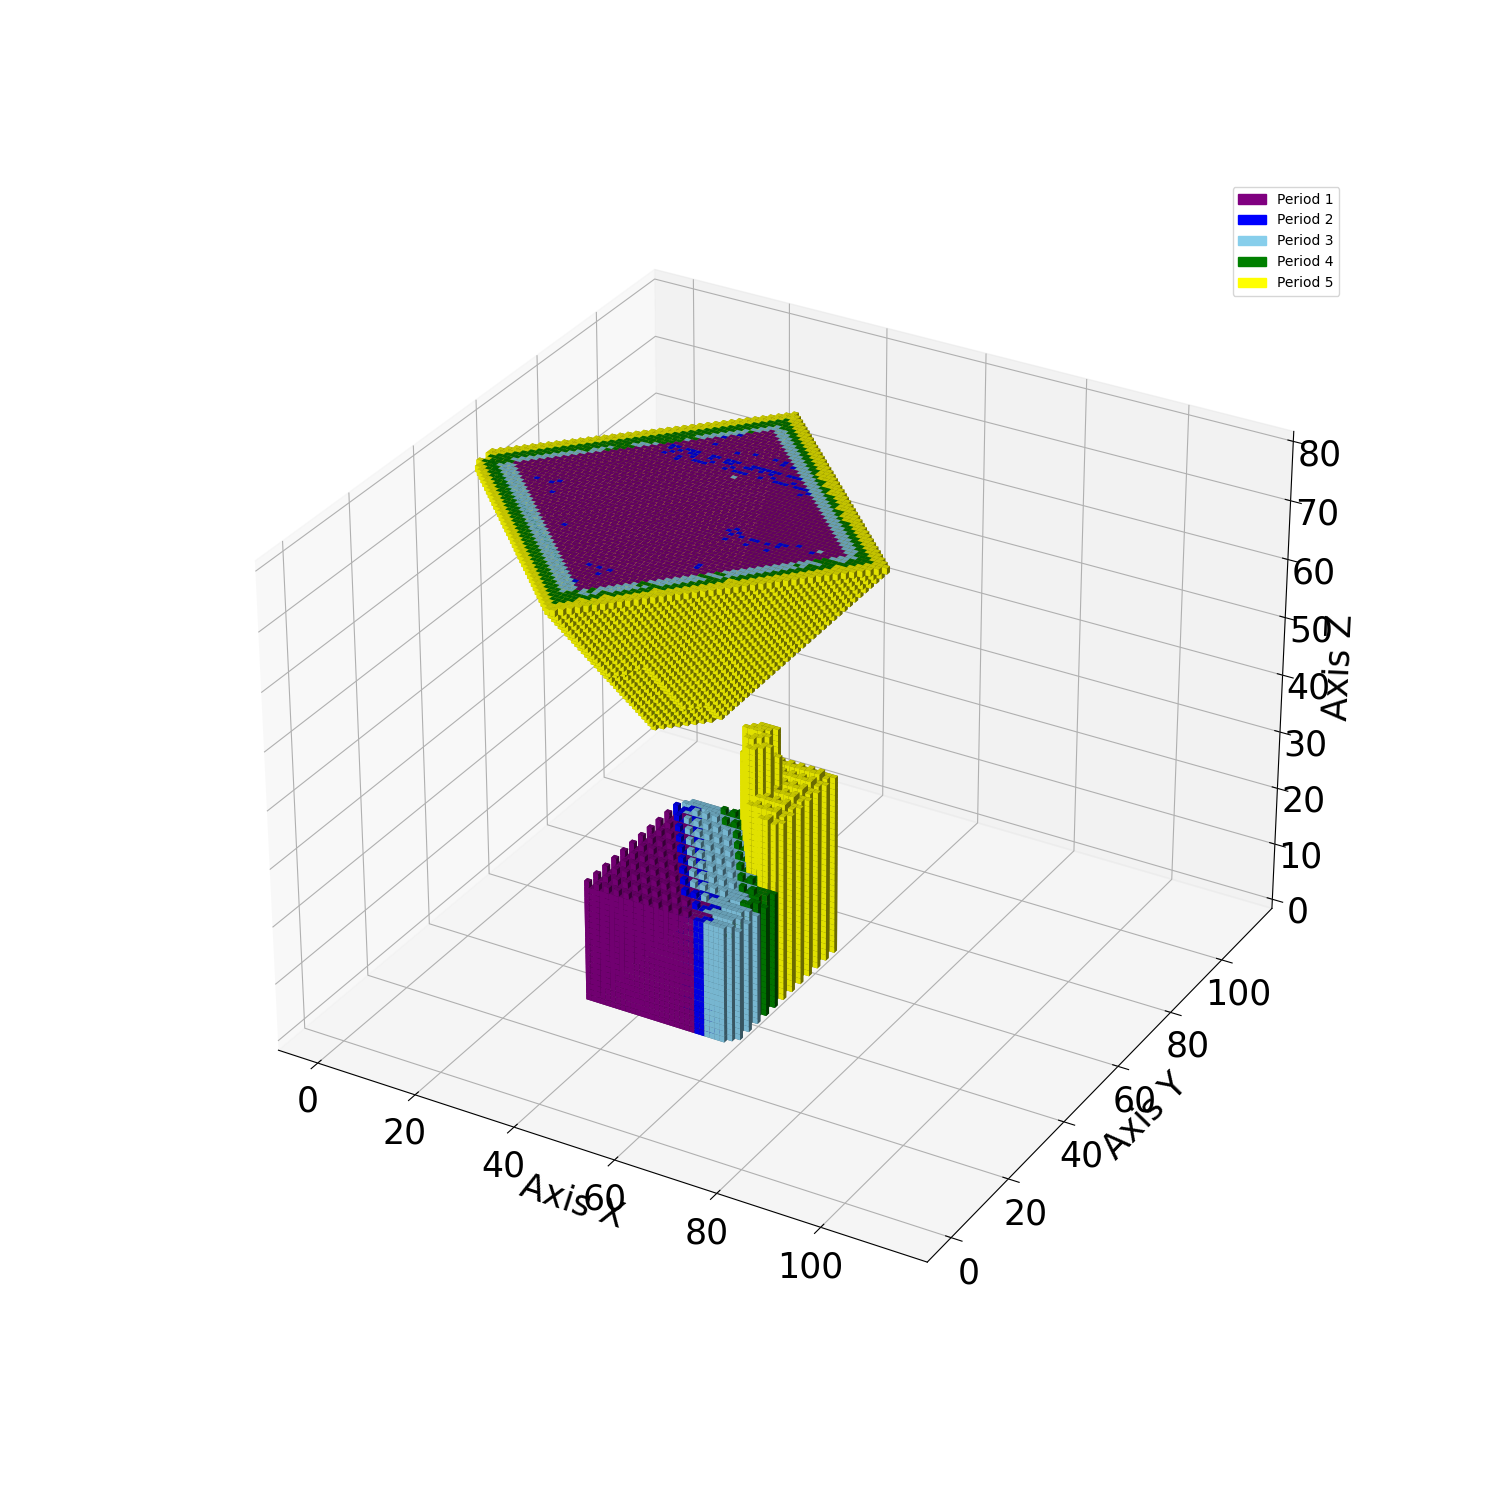

In [ ]:
plotIntegratedOmpSolution(main.MasterProblem.undergroundBlocksLenghtLimits, main.MasterProblem.undergroundBlocksWidthLimits,main.MasterProblem.undergroundBlocksHeightLimits, main.MasterProblem.drawpoints_blocks,main.MasterProblem.x_dt_values , main.MasterProblem.y_dt_values, main.numberOfPeriods,openPitDict)

5 desagregado
Optimal ObjVal: 2742740809.108471
Optimal Theta: 682920000.0
Optimal ObjVal TopoSort: 2742740809.108471
3.2 segs


10 desagregado
Optimal ObjVal: 2268360094.125119
Optimal Theta: 561370000.0
Optimal ObjVal TopoSort: 2268360094.125119
15.4 segs


15 desagregado 
Optimal ObjVal: 1906146810.5342412
Optimal Theta: 469290000.0
Optimal ObjVal TopoSort: 1906146810.5342412 
1min 12 segs



20 desagregado Optimal ObjVal: 1624948384.8196843
Optimal Theta: 399730000.0
Optimal ObjVal TopoSort: 1624948384.8196843
GAP: 0.0 
8min 19.9 segs

10 desagregado

Optimal ObjVal: 2343184937.4682417
Optimal Theta: 640110000.0
Optimal ObjVal TopoSort: 2329594937.4682417
GAP: 0.5799798292781656

5 desagregado

Optimal ObjVal: 2840469882.9332986
Optimal Theta: 781890000.0
Optimal ObjVal TopoSort: 2830099882.9332986
GAP: 0.3650804418771411

15 agregado

Optimal Crown Pillar height: {745: 1.0, 785: 0.0, 825: 0.0, 865: 0.0, 905: 0.0, 945: 0.0, 985: 0.0, 1025: 0.0, 1065: 0.0, 1105: 0.0, 1145: 0.0, 1185: 0.0, 1225: 0.0, 1265: 0.0, 1305: 0.0}
Optimal ObjVal: 1903625419.951932
Optimal Theta: 469290000.0
Optimal ObjVal TopoSort: 1884355419.951932
GAP: 1.0122789808347161

------------------------

VALORES PARA BLOQUES AGREGADOS, SOLUCIÓN RELAJADA


5 PERIODOS: 3.3 segs

* Optimal ObjVal: 2742740809.10847
* Optimal Theta: 682920000.0
* Optimal ObjVal relaxed: 2742740809.108471
* Master problem obj val: 2742740809.108471
* Optimal ObjVal TopoSort: 2742740809.108471

10 PERIODOS: 7.0 segs

* Optimal ObjVal: 2271941260.015317
* Optimal Theta: 561370000.0
* Optimal ObjVal relaxed: 2271941260.015317
* Master problem obj val: 2271941260.015317
* Optimal ObjVal TopoSort: 2271941260.015317
* GAP: 0.0

15 PERIODOS: 14.1 segs

* Optimal ObjVal: 1873723971.8816504
* Optimal Theta: 469290000.0
* Optimal ObjVal relaxed: 1873723971.8816504
* Master problem obj val: 1873723971.8816504
* Optimal ObjVal TopoSort: 1873723971.8816504
* GAP: 0.0

20 PERIODOS: 25.5 segs

* Optimal ObjVal: 1616265630.1377
* Optimal Theta: 399730000.0
* Optimal ObjVal relaxed: 1616265630.1377
* Master problem obj val: 1616265630.1377
* Optimal ObjVal TopoSort: 1616265630.1377
* GAP: 0.0

------------------------

VALORES PARA BLOQUES DESAGREGADOS, SOLUCIÓN RELAJADA


5 PERIODOS: 59.2 segs

* Optimal ObjVal: 2807234376.8134923
* Optimal Theta: 781890000.0
* Optimal ObjVal relaxed: 2807234376.8134923
* Master problem obj val: 2807234376.8134923
* Optimal ObjVal TopoSort: 2807234376.8134923

10 PERIODOS: 1 min 27.3 segs

* Optimal ObjVal: 2353537399.199758
* Optimal Theta: 640110000.0
* Optimal ObjVal relaxed: 2353537399.199758
* Master problem obj val: 2353537399.199758
* Optimal ObjVal TopoSort: 2353537399.199758
* GAP: 0.0

15 PERIODOS: 2 min 10.2 segs

* Optimal ObjVal: 1962744919.4705706
* Optimal Theta: 532320000.0
* Optimal ObjVal relaxed: 1962744919.4705706
* Master problem obj val: 1962744919.4705706
* Optimal ObjVal TopoSort: 1962744919.4705706
* GAP: 0.0

20 PERIODOS: 3 min 0.9 segs

* Optimal ObjVal: 1657095434.8418837
* Optimal Theta: 449440000.0
* Optimal ObjVal relaxed: 1657095434.8418837
* Master problem obj val: 1657095434.8418837
* Optimal ObjVal TopoSort: 1657095434.8418837
* GAP: 0.0

------------------------

VALORES PARA BLOQUES AGREGADOS, SOLUCIÓN ENTERA


5 PERIODOS: 3.2 segs

* Optimal ObjVal: 2742740809.108471
* Optimal Theta: 682920000.0
* Optimal ObjVal relaxed: 2742740809.108471
* Master problem obj val: 2742740809.108471
* Optimal ObjVal TopoSort: 2686060809.108471
* GAP: 2.0665459824628436

10 PERIODOS: 7.0 segs

* Optimal ObjVal: 2271941260.015317
* Optimal Theta: 561370000.0
* Optimal ObjVal relaxed: 2271941260.015317
* Master problem obj val: 2271941260.015317
* Optimal ObjVal TopoSort: 2228841260.015317
* GAP: 1.8970560884883718

15 PERIODOS: 13.9 segs
* Optimal ObjVal: 1873723971.8816504
* Optimal Theta: 469290000.0
* Optimal ObjVal relaxed: 1873723971.8816504
* Master problem obj val: 1873723971.8816504
* Optimal ObjVal TopoSort: 1854453971.8816504
* GAP: 1.0284332318515668

20 PERIODOS: 25.3 segs 

* Optimal ObjVal: 1616265630.1377
* Optimal Theta: 399730000.0
* Optimal ObjVal relaxed: 1616265630.1377
* Master problem obj val: 1616265630.1377
* Optimal ObjVal TopoSort: 1593475630.1377
* GAP: 1.4100405017001056

------------------------

VALORES PARA BLOQUES DESAGREGADOS, SOLUCIÓN ENTERA


5 PERIODOS: 3.3 segs

* Optimal ObjVal: 2807234376.8134923
* Optimal Theta: 781890000.0
* Optimal ObjVal relaxed: 2807234376.8134923
* Master problem obj val: 2807234376.8134923
* Optimal ObjVal TopoSort: 2796864376.8134923
* GAP: 0.3694027148446025

10 PERIODOS: 1 min 27.7 segs

* Optimal ObjVal: 2353537399.199758
* Optimal Theta: 640110000.0
* Optimal ObjVal relaxed: 2353537399.199758
* Master problem obj val: 2353537399.199758
* Optimal ObjVal TopoSort: 2339947399.199758
* GAP: 0.5774286826553436

15 PERIODOS: 2 min 9.8 segs

* Optimal ObjVal: 1962744919.4705706
* Optimal Theta: 532320000.0
* Optimal ObjVal relaxed: 1962744919.4705706
* Master problem obj val: 1962744919.4705706
* Optimal ObjVal TopoSort: 1941014919.4705706
* GAP: 1.1071229778478517

20 PERIODOS: 2 min 59.9 segs

* Optimal ObjVal: 1657095434.8418837
* Optimal Theta: 449440000.0
* Optimal ObjVal relaxed: 1657095434.8418837
* Master problem obj val: 1657095434.8418837
* Optimal ObjVal TopoSort: 1640575434.8418837
* GAP: 0.9969250806352201

------------------------